# Charging the data

## 1. Import libraries

In [71]:
import random

import numpy as np

import pandas as pd

from skimage import filters, io, img_as_ubyte
from skimage.filters import median
from skimage.morphology import disk

from scipy.interpolate import interp1d, RegularGridInterpolator,make_interp_spline
from scipy.integrate import simpson
from scipy.ndimage import convolve1d

from astropy.io import fits
from astropy.convolution import convolve

from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms

import os

from tqdm import tqdm 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


from pathlib import Path


In [72]:
plt.rcParams.update({
  'axes.titlesize': 'x-large',  # heading 1
  'axes.labelsize': 'large',   # heading 2
  'xtick.labelsize': 'medium',         # fontsize of the ticks
  'ytick.labelsize': 'medium',         # fontsize of the ticks
  'font.family': 'serif',        # Font family
  'text.usetex': False,          # Do not use LaTeX for text rendering
  'figure.figsize': (10, 8),     # Default figure size
  'savefig.dpi': 300,            # High resolution for saving figures
  'savefig.format': 'png',       # Default format for saving figures
  'legend.fontsize': 'small',  # Font size for legends
  'lines.linewidth': 2,          # Line width for plots
  'lines.markersize': 8,         # Marker size for plots,
  'axes.formatter.useoffset': False,  # Disable offset
  'axes.formatter.use_mathtext': True,  # Use scientific notation
  'axes.formatter.limits': (-3, 4),  # Use scientific notation for values over 10^2
  'axes.labelsize': 'large',     # Font size for axes labels
  'figure.titlesize': 'xx-large', # Font size for suptitles (heading 1)
  'axes.formatter.use_locale': False  # Do not use locale settings
})


## 2. Atmospheric parameters

### 2.1 Charge the raw data

First let's define the path to the data and use a testing file. Also, some quantities useful for the dimensiones to be treated later in the code.

In [73]:
images_output = Path("../thesis_images")
if not os.path.exists(images_output):
    os.makedirs(images_output)

In [74]:
ptm = Path("/scratchsan/observatorio/juagudeloo/data")
filename = "080000"

nlam = 300 #this parameter is useful when managing the Stokes parameters #wavelenght interval - its from 6300 amstroengs in steps of 10 amstroengs
nx = 480
ny = 480 
nz = 256 #height axis

Charge the data corresponding to temperature, density, magnetic field and velocity

In [75]:
print(f"""
        ######################## 
        Reading {filename} MuRAM data...
        ######################## 
              """)

geom_path = ptm / "geom_height"
print("Charging temperature ...")
mtpr = np.load(geom_path / f"mtpr_{filename}.npy").flatten()
print("mtpr shape:", mtpr.shape)


print("Charging density...")
mrho = np.load(geom_path / f"mrho_{filename}.npy")
print("mrho shape:", mrho.shape)

print("Charge velocity...")
mvzz = np.load(geom_path / f"mvzz_{filename}.npy")
print("mvzz shape:", mvzz.shape)

mvzz = mvzz/mrho

#########################################
mrho = np.log10(mrho) #For better learning
########################################

print("Charging magnetic field vector...")
mbzz = np.load(geom_path / f"mbzz_{filename}.npy")

coef = np.sqrt(4.0*np.pi) #cgs units conversion300

mbzz=mbzz*coef
print("mbzz shape:", mbzz.shape)


muram_box = np.stack([mtpr, mrho, mvzz, mbzz], axis=-1)
muram_box = np.array([mtpr, mrho, mvzz, mbzz])
muram_box = np.moveaxis(muram_box, 0, 1)
muram_box = np.reshape(muram_box, (nx, nz, ny, muram_box.shape[-1]))
muram_box = np.moveaxis(muram_box, 1, 2)

print(f"""
        ######################## 
        Finished!
        ######################## 
              """)

del mtpr, mrho, mbzz, mvzz


        ######################## 
        Reading 080000 MuRAM data...
        ######################## 
              
Charging temperature ...
mtpr shape: (58982400,)
Charging density...
mrho shape: (58982400,)
Charge velocity...
mvzz shape: (58982400,)
Charging magnetic field vector...
mbzz shape: (58982400,)

        ######################## 
        Finished!
        ######################## 
              


In [76]:
muram_box.shape

(480, 480, 256, 4)

For the vertical representation, we'll take the mean value for each surface.

In [77]:

domain_heights = np.array(range(0, 256)) * 10
mean_T = muram_box[...,0].mean(axis = (0,1)) 
T_indices = np.argsort(mean_T)
mean_T = mean_T[T_indices]
domain_heights = domain_heights[T_indices]

Teff = 5780
height_T_func = make_interp_spline(mean_T, domain_heights, k=3)
height_Teff = height_T_func(Teff)
print(f"Height at Teff = {height_Teff} km")

domain_heights = domain_heights - height_Teff
domain_heights = np.sort(domain_heights)/1000 #in Mm




Height at Teff = 1897.479302927621 km


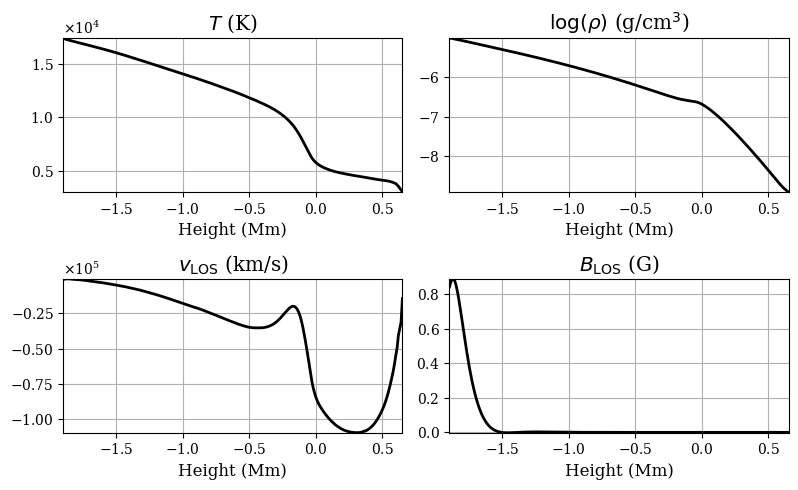

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(2*4, 2*2.5))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\log(\rho)$", r"g/cm$^3$", "summer"),
    (2, r"$v_{\text{LOS}}$", "km/s", "bwr_r"),
    (3, r"$B_{\text{LOS}}$", "G", "PiYG"),
]


for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,param_idx].mean(axis = (0,1)) 
  if title in [r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
    
  iax = ax[i // 2, i % 2]
  
  iax.plot(domain_heights, data, "k")
  iax.set_xlabel("Height (Mm)")
  iax.set_title(f"{title} ({unit})")
  iax.set_xlim(domain_heights.min(), domain_heights.max())
  iax.grid(True)
  iax.set_ylim(data.min(), data.max())
plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "muram_box_mean_profile.png", dpi=300)

plt.show()


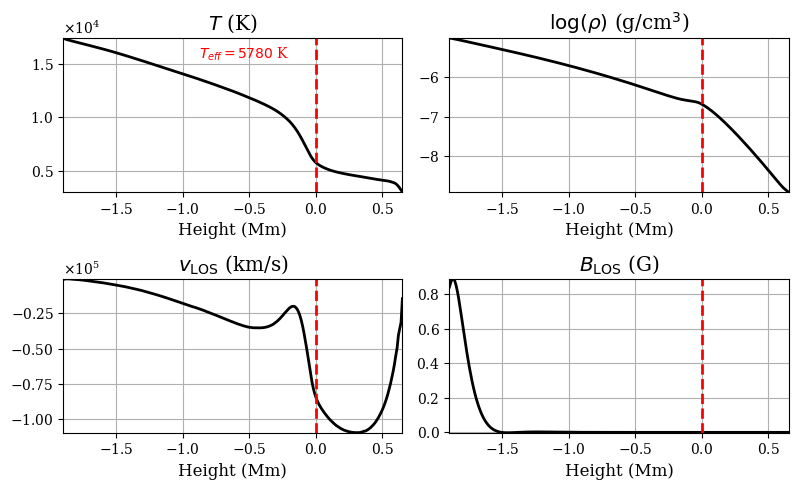

In [79]:
fig, ax = plt.subplots(2, 2, figsize=(2*4, 2*2.5))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\log(\rho)$", r"g/cm$^3$", "summer"),
    (2, r"$v_{\text{LOS}}$", "km/s", "bwr_r"),
    (3, r"$B_{\text{LOS}}$", "G", "PiYG"),
]

for i, (param_idx, title, unit, cmap) in enumerate(quantities):
    data = muram_box[...,param_idx].mean(axis = (0,1)) 
    if title in [r"$v_z$"]:  # Convert from cm/s to km/s
        data /= 1e5
    
    iax = ax[i // 2, i % 2]
    
    iax.plot(domain_heights, data, "k")
    iax.axvline(x=0, color='red', linestyle='--')
    if title == r"$T$":
        iax.text(0.4, 0.95, r'$T_{eff} = 5780$ K', color='red', transform=iax.transAxes, verticalalignment='top')
    iax.set_xlabel("Height (Mm)")
    iax.set_title(f"{title} ({unit})")
    iax.set_xlim(domain_heights.min(), domain_heights.max())
    iax.grid(True)
    iax.set_ylim(data.min(), data.max())
plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "muram_box_mean_profile_with_teff.png", dpi=300)

plt.show()

Let's plot them to check their distribution along height and over a surface

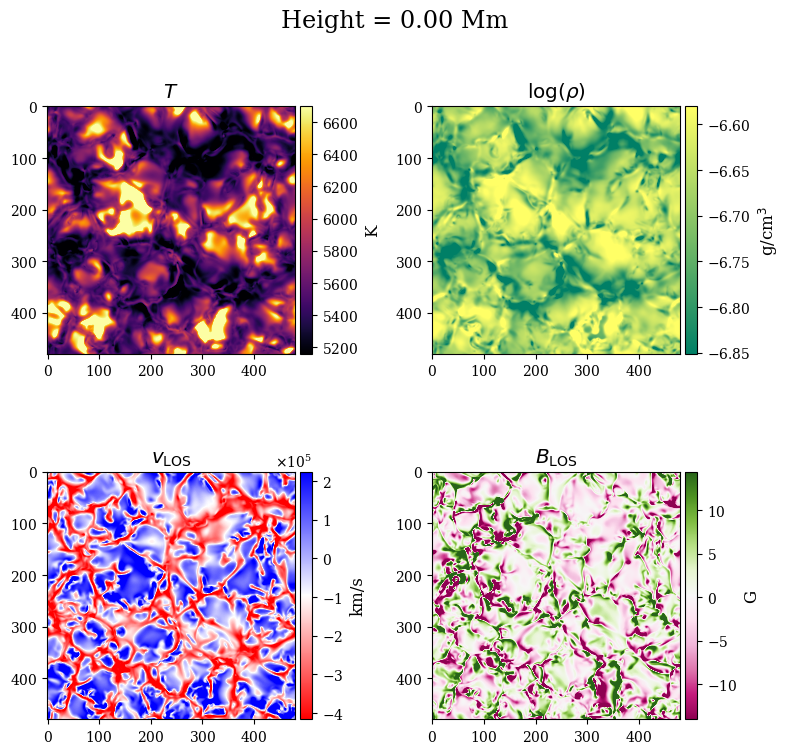

In [80]:
height_pix = 190
fig, ax = plt.subplots(2, 2, figsize=(2*4, 2*4))
fig.suptitle(f"Height = {domain_heights[height_pix]:.2f} Mm")
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,height_pix,param_idx]
  if title in [r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$v_z$", r"$B_z$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 2, i % 2].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 2, i % 2].set_title(title)
  divider = make_axes_locatable(ax[i // 2, i % 2])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_height.png", dpi=300)

plt.show()

In [81]:
first_positive_index = np.argmax(domain_heights > 0)
print(first_positive_index)

190


### 2.2 Optical Depth Stratification

Once we have the respective quantities charged, we would like to stratify the magnitudes with respect to logarithm of optical depth nodes $\log \tau$ for a comparison of the results with real data. Let's do it with just one pixel. The nodes we are gonna use correspond to the [MODEST dataset](https://www.aanda.org/articles/aa/abs/2024/07/aa49269-24/aa49269-24.html), which values are $\log \tau = 0, -0.8, -2.0$.

First, let's charge the pressure data corresponding to our simulation snapshot.

In [82]:
 # Load the pressure
eos = np.fromfile(os.path.join(geom_path,  f"eos.{filename}"), dtype=np.float32)
eos = eos.reshape((2, nx, nz, ny), order = "C")
mpre = eos[1]
mpre = np.moveaxis(mpre, 1, 2)  # Pressure array to be used in the calculation of the optical depth
del eos
mpre.shape

(480, 480, 256)

For doing the stratification corresponding to optical depth, we will use the following calculation
\begin{equation}
    \tau(z;T,P) = \int_{z_{\text{max}}}^{z} \kappa(T,P) \log(\rho) dz
\end{equation}
which correspond to the calculation of the optical depth parting from the opacity values multiplied by the volumetric density of the gas. This calculation correspond to the assumption of parallel atmospheres that can be applied on the photosphere thanks to it's behaviour that can be described aproximately through local thermodynamic equilibrium (LTE).

To this purpose we'll do the spline interpolation of the values corresponding to the Rosseland opacity related to specific values of Temperature and pressure

In [83]:
 # Upload the opacity data
tab_T = np.array([3.32, 3.34, 3.36, 3.38, 3.40, 3.42, 3.44, 3.46, 3.48, 3.50,
                3.52, 3.54, 3.56, 3.58, 3.60, 3.62, 3.64, 3.66, 3.68, 3.70,
                3.73, 3.76, 3.79, 3.82, 3.85, 3.88, 3.91, 3.94, 3.97, 4.00,
                4.05, 4.10, 4.15, 4.20, 4.25, 4.30, 4.35, 4.40, 4.45, 4.50,
                4.55, 4.60, 4.65, 4.70, 4.75, 4.80, 4.85, 4.90, 4.95, 5.00,
                5.05, 5.10, 5.15, 5.20, 5.25, 5.30]) #log(T) in K

tab_p = np.array([-2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5,
                3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7., 7.5, 8.]) #log(P) in dyne/cm^2

df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)
df_kappa.columns = ["Temperature index", "Pressure index", "Opacity value"]
temp_indices = df_kappa["Temperature index" ].unique()
press_indices = df_kappa["Pressure index"].unique()
opacity_values = df_kappa.pivot(index = "Pressure index", columns = "Temperature index", values = "Opacity value").values

Tk = tab_T[temp_indices]
Pk = tab_p[press_indices]
K = opacity_values

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3302405/2204471890.py:12: SyntaxWarning: invalid escape sequence '\s'
  df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)


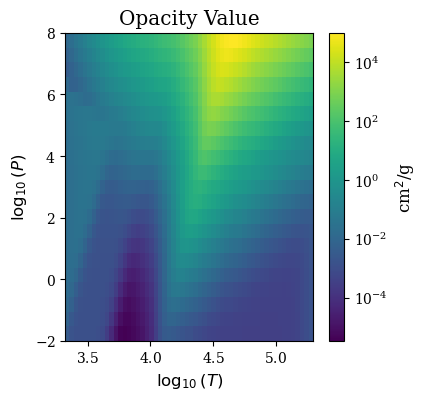

In [84]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
# Plot the 2D colormap with log normalization
cax = ax.imshow(K, cmap='viridis', aspect='auto', extent=[Tk.min(), Tk.max(), Pk.min(), Pk.max()], origin='lower', norm=LogNorm())

ax.set_xlabel(r'$\log_{10}(T)$')
ax.set_ylabel(r'$\log_{10}(P)$')
ax.set_title('Opacity Value')

fig.colorbar(cax, ax=ax, label=r'cm$^2$/g')
fig.savefig(images_output / "opacity_values.png")
plt.show()


Let's check that the temperature and pressure values we have in our dataset are inside the limits of our opacity temperature and pressure ranges.

In [85]:
def limit_values(data, min_val, max_val):
        new_data = np.clip(data, min_val+0.00001, max_val-0.00001)
        return new_data
                
T_log = np.log10(muram_box[..., 0]) 
P_log = np.log10(mpre) 
T_log = limit_values(T_log, Tk.min(), Tk.max())
P_log = limit_values(P_log, Pk.min(), Pk.max())
PT_log = np.stack((P_log.flatten(), T_log.flatten()), axis=-1)

Define the interpolator for obtaining the corresponding opacity values to our simulation distribution of temperature and pressure.

In [86]:
kappa_interp = RegularGridInterpolator((Pk,Tk), K, method="linear")

Now, let's apply the interpolation and create an array for the $\kappa\log(\rho)$ distribution.

In [87]:
kappa_rho = np.zeros_like(muram_box[..., 0])
kappa_rho = kappa_interp(PT_log)
kappa_rho = kappa_rho.reshape(muram_box[...,0].shape)
kappa_rho = np.multiply(kappa_rho, muram_box[..., 1])

Finally, let's integrate for each pixel under the parallel-plane atmosphere assumption

In [88]:
#Optical depth calculation
logtau_name = f"logtau_{filename}.npy"
if not os.path.exists(geom_path / logtau_name): #In case the optical depth has not been calculated yet
    tau = np.zeros_like(kappa_rho)
    dz = 1e6 # 10 km -> 1e6 cm
    tau[:,:,nz-1] = 1e-5

    print("Calculating optical depth...")
    for iz in tqdm(range(1,nz)):
        for ix in range(nx):
            for iy in range(ny):
                kpz = kappa_rho[ix,iy,nz-1-iz:]
                tau[ix,iy,nz-1-iz] = simpson(y = kpz, 
                                    dx = dz)
                
    muram_logtau = np.log10(tau)
    np.save(geom_path / logtau_name, muram_logtau)
    
else: #For visualization is better to load the optical depth values from the file for fast demonstration
    muram_logtau = np.load(geom_path / logtau_name)

Now that we have the logtau distribution of values, we will interpolate over each of the pixels to obtain the three nodes we are interested in.

In [89]:
#New logtau nodes
new_logtau = np.arange(-2.0,0.1,0.1)
n_logtau = new_logtau.shape[0]

In [90]:
new_logtau

array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        1.77635684e-15])

Let's define a function that maps the simulation values to our new nodes for a sole pixel

In [91]:
def logtau_mapper(orig_arr: np.ndarray, 
    corresp_logtau: np.ndarray,
    new_logtau: np.ndarray,
    ) -> np.ndarray:
        """
        Function for mapping the quantities distribution from geometrical height to optical depth.
        Args:
            orig_arr(np.ndarray): Original array distributed along geometrical height to be mapped.
            corresp_logtau(np.ndarray): Distribution of optical depth for the original array.
            new_logtau(np.ndarray): Array of the new optical depth measurement of height for the mapping
        Returns:
            (np.ndarray) Array containing the mapped quantity to the new distribution on optical depth.
        """
        
        logtau_mapper = interp1d(x = corresp_logtau, y = orig_arr)
        new_arr = logtau_mapper(new_logtau)
        return new_arr

Now, for each quantity we must interpolate over each of the simulations surface pixels to obtain their values in each of the three nodes.

In [92]:
opt_path = ptm / "opt_depth"
output_names = ["mtpr","mrho", "mvzz", "mbzz"]

In [93]:
#Pixel by pixel iteration

#1. Atmospheric quantities iteration
atm_to_logtau = np.zeros((nx,ny,n_logtau,muram_box.shape[-1]))
for imur in range(muram_box.shape[-1]):
    out_map_name = f"{output_names[imur]}_logtau_{filename}_{n_logtau}_nodes.npy"
    
    # Check if the file exists
    if not os.path.exists(opt_path / out_map_name):
        #2. Pixel iteration
        geom_atm = muram_box[..., imur]
        new_muram_quantity = np.zeros((nx,ny,n_logtau))
        for ix in tqdm(range(nx)):
            for iy in range(ny):
                new_muram_quantity[ix,iy,:] = logtau_mapper(orig_arr = geom_atm[ix,iy,:], 
                                            corresp_logtau = muram_logtau[ix,iy,:], 
                                            new_logtau = new_logtau)
        atm_to_logtau[...,imur] = new_muram_quantity
        np.save(opt_path / out_map_name, new_muram_quantity)
        print(f"Saved to {opt_path / out_map_name}")
    else:
        # Load the file
        atm_to_logtau[...,imur] = np.load(opt_path / out_map_name)
        print(f"Loaded {output_names[imur]} from {opt_path / out_map_name}")
muram_box = atm_to_logtau

Loaded mtpr from /scratchsan/observatorio/juagudeloo/data/opt_depth/mtpr_logtau_080000_21_nodes.npy
Loaded mrho from /scratchsan/observatorio/juagudeloo/data/opt_depth/mrho_logtau_080000_21_nodes.npy
Loaded mvzz from /scratchsan/observatorio/juagudeloo/data/opt_depth/mvzz_logtau_080000_21_nodes.npy
Loaded mbzz from /scratchsan/observatorio/juagudeloo/data/opt_depth/mbzz_logtau_080000_21_nodes.npy


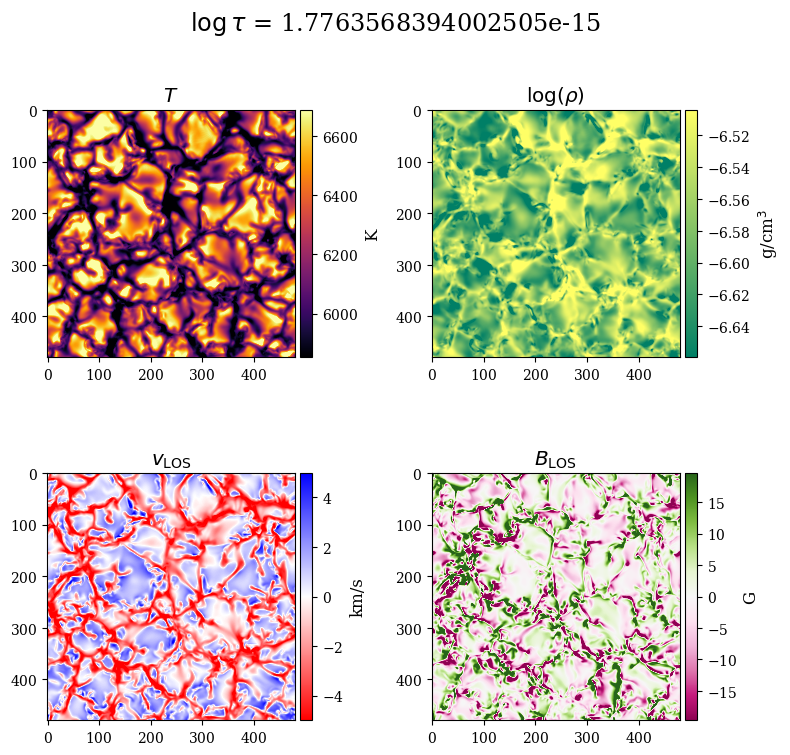

In [94]:
height_pix = -1
fig, ax = plt.subplots(2, 2, figsize=(2*4, 2*4))
fig.suptitle(r"$\log \tau$" + f" = {new_logtau[height_pix]}")
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,height_pix,param_idx]
  if title in [r"$v_{\text{LOS}}$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$v_{\text{LOS}}$", r"$B_{\text{LOS}}$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 2, i % 2].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 2, i % 2].set_title(title)
  divider = make_axes_locatable(ax[i // 2, i % 2])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_opt_depth.png", dpi=300)

plt.show()

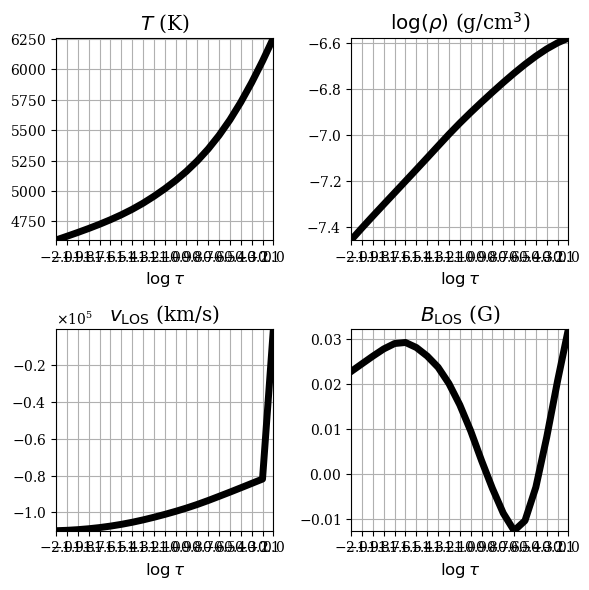

In [95]:
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\log(\rho)$", r"g/cm$^3$", "spring"),
    (2, r"$v_{\text{LOS}}$", "km/s", "bwr_r"),
    (3, r"$B_{\text{LOS}}$", "G", "PiYG"),
]

for i, (param_idx, title, unit, cmap) in enumerate(quantities):
    data = muram_box[..., param_idx].mean(axis=(0, 1))
    iax = ax[i // 2, i % 2]
    if title == r"$log(\log(\rho))$":
        data = np.log10(data)
        iax.plot(new_logtau, data, "k", linewidth=5)
    elif title == r"$v_z$":
        data = data / 1e5
        iax.plot(new_logtau, data, "k", linewidth=5)
    else:
        iax.plot(new_logtau, data, "k", linewidth=5)
    iax.set_xlabel(r"$\log \tau$")
    iax.set_title(f"{title} ({unit})")
    iax.set_xlim(new_logtau.min(), new_logtau.max())
    iax.grid(True)
    iax.set_ylim(data.min(), data.max())
    iax.set_xticks(new_logtau)

plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "mean_profile_along_optical_depth.png", dpi=300)
plt.show()

### 2.3 Resizing to Hinode resolution

Let's itemize what we have

Simulation spatial grid:

- $12 \times 12$ Mm domain
- $480 \times 480$ pixels
- Each pixel = 25 km per pixel

Hinode/SOT-SP spatial resolution:

- Ground Sampling: ~$0.16''$ per pixel
- At disk center, $1''$ ≈ 725 km, so:

$0.16''\times 725$ km/arcsec $\approx 116$ km per pixel. Which means then that if we want to match the exact Hinode spatial sampling, we have a

\begin{equation}
    \text{Scaling factor} =  \frac{116\,\text{km/pix}}{25\,\text{km/pix}} = 4.64
\end{equation}

Then, using the Pytorch `resize` transformation, we have
 

In [96]:
# Target pixel size:
target_pixel_size_km = 116
current_pixel_size_km = 25
scaling_factor = current_pixel_size_km / target_pixel_size_km

target_size = int(480 * scaling_factor)  # ~103 pixels

resize = transforms.Resize((target_size, target_size), interpolation=transforms.InterpolationMode.BICUBIC)
resize

Resize(size=(103, 103), interpolation=bicubic, max_size=None, antialias=True)

In [97]:
muram_box.shape

(480, 480, 21, 4)

In [98]:
new_surface_dimensions = resize.size
resampled_atm = np.zeros((new_surface_dimensions[0], new_surface_dimensions[1], muram_box.shape[2], muram_box.shape[3]))

for atm_mag in tqdm(range(muram_box.shape[-1])):
    for itau in range(muram_box.shape[2]):
        resampled_atm[..., itau, atm_mag] = resize(torch.tensor(muram_box[..., itau, atm_mag]).unsqueeze(0).unsqueeze(0)).numpy().squeeze()

100%|██████████| 4/4 [00:00<00:00, 52.66it/s]


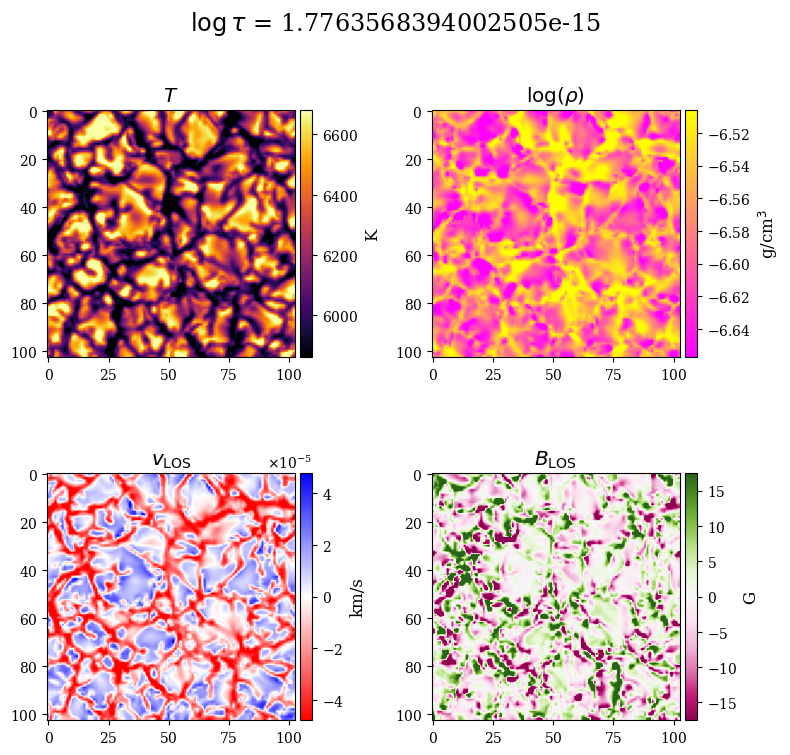

In [99]:
height_pix = -1
fig, ax = plt.subplots(2, 2, figsize=(2*4, 2*4))
fig.suptitle(r"$\log \tau$" + f" = {new_logtau[height_pix]}")
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = resampled_atm[...,height_pix,param_idx]
  if title in [r"$v_{\text{LOS}}$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$v_{\text{LOS}}$", r"$B_{\text{LOS}}$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 2, i % 2].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 2, i % 2].set_title(title)
  divider = make_axes_locatable(ax[i // 2, i % 2])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_opt_depth.png", dpi=300)

plt.show()

### 2.4 Atmospheric magnitudes max-min scaling

For the data to be treated by the neural network models, it is necessary to scale it. First, let's check the values of the magnitudes so that we are sure they were correctly scaled.

In [100]:
print(f"""
MAX VALUES:
mtpr max = {np.max(resampled_atm[...,:,:,0])}
mrho max = {np.max(resampled_atm[...,:,:,1])}
mvzz max = {np.max(resampled_atm[...,:,:,2])}
mbzz max = {np.max(resampled_atm[...,:,:,3])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(resampled_atm[...,:,:,0])}
mrho min = {np.min(resampled_atm[...,:,:,1])}
mbzz min = {np.min(resampled_atm[...,:,:,2])}
mvzz min = {np.min(resampled_atm[...,:,:,3])}
    """) 


MAX VALUES:
mtpr max = 7000.236898901304
mrho max = -6.423388340788872
mvzz max = 547610.7695823672
mbzz max = 108.3795984330301
    

MIN VALUES:
mtpr min = 3672.0009209846176
mrho min = -7.606535300448495
mbzz min = -776831.5765007345
mvzz min = -83.02258656560522
    


Now, let's define the scaling factors. For the Stokes parameters we will normalize by the continuum of the intensity, while for the atmospheric magnitudes we will use scale factors determined in terms of the mean maximum and minimum values of each magnitude along all the steps of the simulation. This study is shown [in this other notebook](./Check_data.ipynb).

In [101]:
#Atmosphere magnitudes scale factors
phys_maxmin = {}
phys_maxmin["T"] = [2e4, 0]
phys_maxmin["Rho"] = [1e-5, 1e-10]
phys_maxmin["V"] = [1e6, -1e6]
phys_maxmin["B"] = [3e3, -3e3]
phys_maxmin["Gamma"] = [180, 0] #restriction for cavoiding azimuth ambiguity
phys_maxmin["Phi"] = [90, -90]

Let's define a minmax normalizing function.

In [102]:
def norm_func(arr, maxmin):
    max_val = maxmin[0]
    min_val = maxmin[1]
    return (arr-min_val)/(max_val-min_val)

Apply the scaling function on the muram data

In [103]:
scaled_atm = np.zeros_like(resampled_atm)
#Atmosphere magnitudes normalization
scaled_atm[...,0] = norm_func(resampled_atm[...,0], phys_maxmin["T"])
scaled_atm[...,1] = norm_func(resampled_atm[...,1], phys_maxmin["Rho"])
scaled_atm[...,2] = norm_func(resampled_atm[...,3], phys_maxmin["V"])
scaled_atm[...,3] = norm_func(resampled_atm[...,2], phys_maxmin["B"])

Let's check the new maximum and minimum values.

In [104]:
print(f"""
MAX VALUES:
mtpr max = {np.max(scaled_atm[...,:,:,0])}
mrho max = {np.max(scaled_atm[...,:,:,1])}
mvzz max = {np.max(scaled_atm[...,:,:,2])}
mbzz max = {np.max(scaled_atm[...,:,:,3])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(scaled_atm[...,:,:,0])}
mrho min = {np.min(scaled_atm[...,:,:,1])}
mbzz min = {np.min(scaled_atm[...,:,:,2])}
mvzz min = {np.min(scaled_atm[...,:,:,3])}
""")


MAX VALUES:
mtpr max = 0.3500118449450652
mrho max = -642345.2575414625
mvzz max = 0.5000541897992166
mbzz max = 91.76846159706119
    

MIN VALUES:
mtpr min = 0.18360004604923089
mrho min = -760661.1366662161
mbzz min = 0.4999584887067172
mvzz min = -128.9719294167891



## 3. Stokes parameters

### 3.1 Charge the Stokes parameters

Having the atmosphere magnitudes charged, we need to charge now the radiation information contained in the Stokes parameters generated for our simulation.

In [105]:
print("Charging Stokes vectors...")
stokes = np.load(ptm / "stokes" / f"{filename}_prof.npy")
print("Charged!")
print("stokes shape", stokes.shape)

Charging Stokes vectors...


Charged!
stokes shape (480, 480, 300, 4)


The wavelength points generated from the simulation are $300$ spectral points of $0.01\,\text{\AA}$ beginning from $6300.5\,\text{\AA}$, containing the FeI spectral lines $6301.5\,\text{\AA}$ and $ 6302.5\,\text{\AA}$.

In [106]:
wl = (np.arange(300) * 0.01  + 6300) 

For further visualizations, let's select a random pixel to make spectral experiments.

test_x: 309, test_y: 100


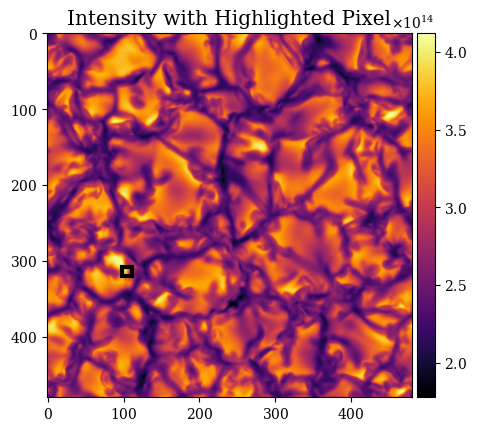

In [107]:
test_x = stokes[...,-1,0].argmax(axis = 0)[100]
test_y = stokes[test_x,:,-1,0].argmax(axis = 0)

print(f"test_x: {test_x}, test_y: {test_y}")

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the intensity (Stokes I) at the specified wavelength pixel
data = stokes[..., 0, 0]
im = ax.imshow(data, cmap='inferno')

# Add a thick black rectangle to highlight the selected pixel
rect = patches.Rectangle((test_y - 1.5, test_x - 1.5), 3*4, 3*4, linewidth=3, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_title("Intensity with Highlighted Pixel")
plt.show()

### 3.2 Spectra normalization

In astronomical sciences, it is common practice to normalize all the presented spectra to the continuum so that you are able to visualize the general behaviour of the spectra independent of the instrument measuring it. For this, we will choose manually some continuum dots.

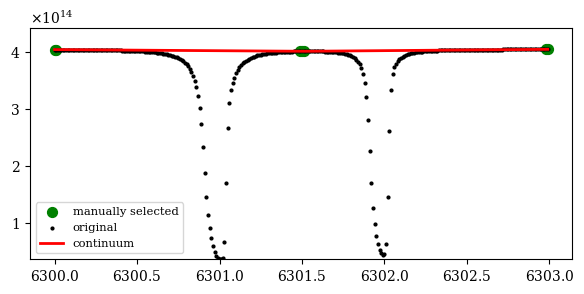

In [108]:
#Selection of the indices that we assume generally correspond to continuum in our data.
cont_indices = [0,1,int(len(wl)/2)-1,int(len(wl)/2),int(len(wl)/2)+1,-2,-1]


wl_cont_values = wl[cont_indices] #corresponding wavelength values to the selected continuum indices
cont_values = stokes[test_x, test_y,cont_indices,0] #corresponding intensity values to the selected continuum indices

cont_model = interp1d(wl_cont_values, cont_values, kind="linear") #Interpolation applied over the assumed continuum values

fig, ax = plt.subplots(figsize = (7,3))
ax.scatter(wl_cont_values, cont_values, label = "manually selected", color = "green", s = 50)
ax.scatter(wl, stokes[test_x, test_y, :, 0], label = "original", color = "black", s = 4)
ax.plot(wl, cont_model(wl), label="continuum", color = "red")
ymin = np.min(stokes[test_x, test_y,:,0])
ymax = np.max(stokes[test_x, test_y,:,0])
ax.set_ylim((ymin, ymax+ymin))
ax.legend()
fig.savefig(images_output / "continuum_interpolation.png", dpi=300)
plt.show()

Let's create a function for doing it independent of the size of our spectral cube for our respective surface.

In [109]:
def continuum_normalization(spectral_cube: np.ndarray, wl_array: np.ndarray) -> np.ndarray:
    """
    Function to normalize the spectral cube by continuum normalization.
    Args:
        spectral_cube(np.ndarray): Spectral cube to be normalized.
        wl_array(np.ndarray): Wavelength array.
    Returns:
        (np.ndarray) Normalized spectral
    """
    cont_indices = [0,1,int(len(wl_array)/2)-1,int(len(wl_array)/2),int(len(wl_array)/2)+1,-2,-1]

    wl_cont_values = wl_array[cont_indices]
    # Vectorized interpolation for speedup
    # cont_values = spectral_cube[:, :, cont_indices, 0].mean(axis = 2).flatten().mean()  # corresponding intensity values to the selected continuum indices
    # cont_model = interp1d(wl_cont_values, cont_values, kind="linear", axis=2)  # Interpolation applied over the assumed continuum values
    I_c =  spectral_cube[:, :, cont_indices, 0].mean(axis = 2).flatten().mean()
    # Apply the normalization
    norm_spectral_cube = np.zeros_like(spectral_cube)
    #mean_continuum_image = cont_model(wl_array).mean(axis=2)
    mean_continuum_image = spectral_cube[:, :, cont_indices, 0].mean(axis = 2)
    for i in range(spectral_cube.shape[-1]):
        norm_spectral_cube[..., i] = spectral_cube[..., i]/ I_c

    mean_continuum_image /= I_c
    return norm_spectral_cube, mean_continuum_image



In [110]:
norm_stokes, mean_continuum = continuum_normalization(stokes, wl)
old_mean_continuum = mean_continuum.copy()

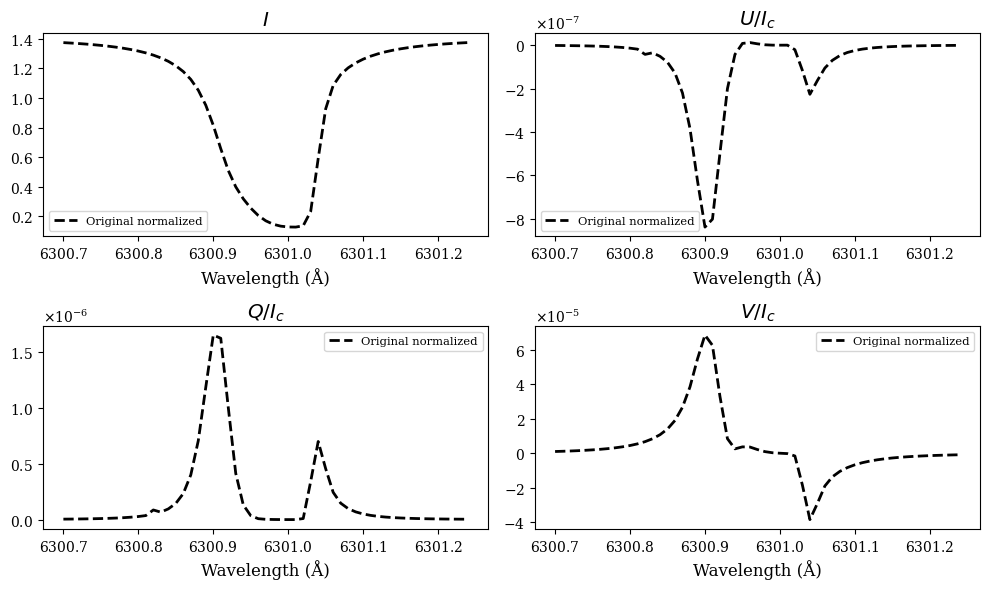

In [111]:
fig, ax = plt.subplots(2,2, figsize = (2*5,2*3))
stokes_titles = [r"$I$", r"$Q/I_c$", r"$U/I_c$", r"$V/I_c$"]
for i in range(len(stokes_titles)):
    row, column = i % 2, i // 2
    ax[row, column].plot(wl[70:125], norm_stokes[test_x, test_y, 70:125, i], "--k", label="Original normalized")
    ax[row, column].set_title(stokes_titles[i])
    ax[row, column].set_xlabel("Wavelength (Å)")
    ax[row, column].legend()
    fig.tight_layout()
plt.show()

### 3.3 Visualize!

Let's check how our spectropolarimetric data looks for the mean continuum and the polarization states, and on the pixel we defined previously.

wavelength step= 0.010 amstrongs


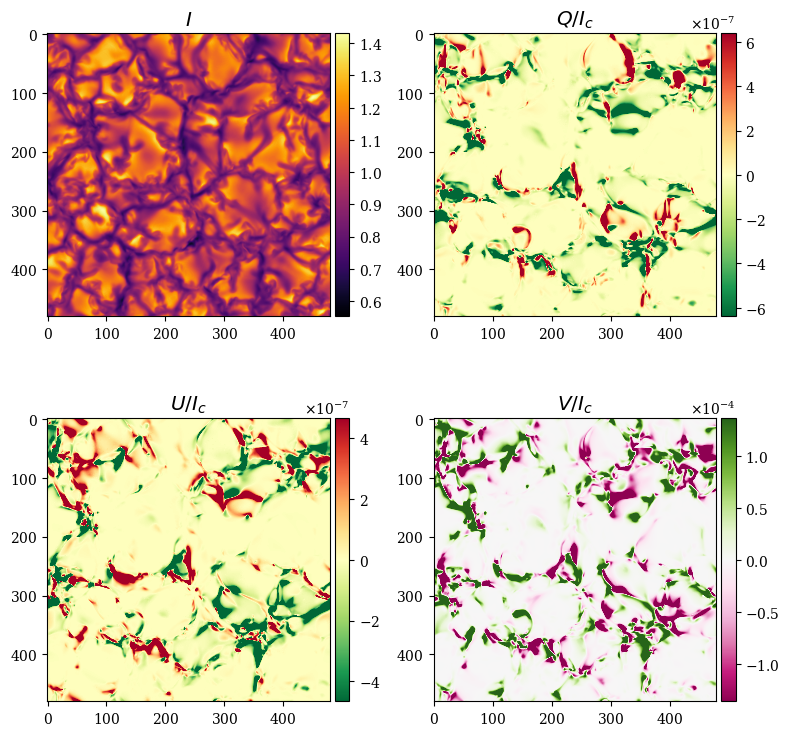

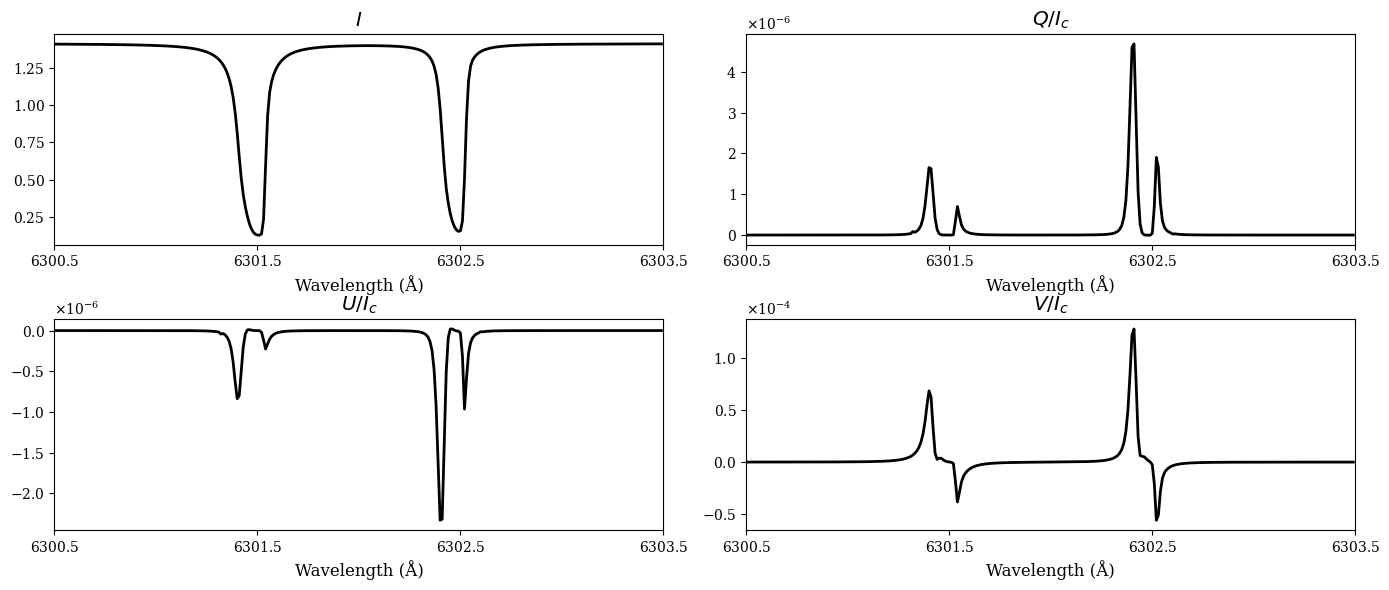

In [112]:
wl_pix = 100 #pixel in the continuum
stokes_titles = [r"$I$", r"$Q/I_c$", r"$U/I_c$", r"$V/I_c$"]
colormaps = ["inferno", "RdYlGn_r", "RdYlGn_r", "PiYG"]

# Surface plot
fig, ax = plt.subplots(2, 2, figsize=(2*4, 2*4))
norm_stokes, mean_continuum = continuum_normalization(stokes, wl)
old_mean_continuum = mean_continuum.copy()
print(r"wavelength step" + f"= {wl[1] - wl[0]:.3f} amstrongs")

for i in range(len(stokes_titles)):
    if i > 0:  # Apply restriction for Q, U, V
        data =norm_stokes[..., wl_pix, i]
        q5, q95 = np.percentile(data, [5, 95])
        vmin = -max(abs(q5), abs(q95))
        vmax = max(abs(q5), abs(q95))
    else:
        data = mean_continuum
        vmin, vmax = data.max(), data.min()
    im = ax[i // 2, i % 2].imshow(data, cmap=colormaps[i], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax[i // 2, i % 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    ax[i // 2, i % 2].set_title(stokes_titles[i])
fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "stokes_surface_plot.png", dpi=300)
plt.show()

# Spectral plot
fig, ax = plt.subplots(2, 2, figsize=(2*7, 2*3))
wl = np.arange(6300.5, 6303.5, 0.01)
for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(wl, norm_stokes[test_x, test_y,:,i], "k")
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(wl.min(), wl.max())
    ax[i // 2, i % 2].set_xticks([6300.5, 6301.5, 6302.5, 6303.5])
fig.tight_layout(w_pad=1.0, h_pad=0.01)
fig.savefig(images_output / "stokes_spectral_plot.png", dpi=300)
plt.show()


## 4. Stokes HINODE/SOT-SP adaptation

Let's define a function for visualizing the total polarimetry for not taking just one wavelength point.

In [113]:
def check_overflow(data, name):
    """Check for NaN, inf values or extremely large numbers in data"""
    has_nan = np.isnan(data).any()
    has_inf = np.isinf(data).any()
    has_huge = (np.abs(data) > 1e30).any()
    
    if has_nan or has_inf or has_huge:
        print(f"WARNING: {name} has problems:")
        print(f"  - NaN values: {has_nan}")
        print(f"  - Inf values: {has_inf}")
        print(f"  - Extremely large values: {has_huge}")
        
        if has_nan:
            print(f"  - NaN count: {np.isnan(data).sum()}")
        if has_inf:
            print(f"  - Inf count: {np.isinf(data).sum()}")
        if has_huge:
            huge_vals = data[np.abs(data) > 1e30]
            print(f"  - Huge values: {huge_vals[:5]} ...")
        
        return True
    return False
def spectropolarimetry(stokes: np.ndarray) -> np.ndarray:
    """
    Function to calculate the polarization degree and angle from the Stokes parameters.
    Args:
        stokes(np.ndarray): Array containing the Stokes parameters.
    Returns:
        (np.ndarray) Array containing the polarization degree and angle.
    """
    I,Q, U, V = stokes[..., 0], stokes[..., 1], stokes[..., 2], stokes[..., 3]
    nwl_points = stokes.shape[-2]

    # Avoid division by zero
    epsilon = 1e-10
    I_safe = np.maximum(I, epsilon)
    
    linear_polarization = np.sqrt(np.sum(Q, axis = -1)**2 + np.sum(U, axis = -1)**2)/ np.sum(I_safe, axis = -1)
    circular_polarization = np.sum(np.abs(V)/I_safe, axis=-1) / nwl_points
    
    # Check for overflow
    check_overflow(np.sum(Q**2, axis = -1), "Q square")
    check_overflow(np.sum(U**2, axis = -1), "U square")
    check_overflow(linear_polarization, "linear_polarization")
    check_overflow(circular_polarization, "circular_polarization")
    
    return linear_polarization, circular_polarization

A common metric for analyzing the contrast in an image, that should be reduced when a PSF convolution is applied, is the RMS metric. Let's define a function for it

In [114]:
def rms_calculation(data: np.ndarray) -> float:
    return np.sqrt(np.mean((data - data.mean())**2))/data.mean()

Let's create the polarization information for the stokes without processing

In [115]:
old_norm_linear_polarization, old_norm_circular_polarization = spectropolarimetry(norm_stokes)

Let's create a function that is going to be useful for visualizing the mean continuum and polarization states through the different processing states.

In [116]:
def plot_polarizations(mean_continuum_data: np.ndarray, 
                       linear_polarization_data: np.ndarray, 
                       circular_polarization_data: np.ndarray,
                       rms: list[float, float, float] = None) -> None:
    """
    Function to plot the mean continuum, linear polarization, and circular polarization.
    Args:
        mean_continuum_data(np.ndarray): Array containing the mean continuum.
        linear_polarization_data(np.ndarray): Array containing the linear polarization.
        circular_polarization_data(np.ndarray): Array containing the circular polarization.
    Returns:
        None
    """
    fig, ax = plt.subplots(1, 3, figsize=(3*4.3, 4.3))

    # Plot mean_continuum
    im1 = ax[0].imshow(mean_continuum_data, cmap='inferno')
    divider1 = make_axes_locatable(ax[0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)

    # Plot old_norm_linear_polarization
    q_low, q_high = np.percentile(linear_polarization_data, [0, 100])
    im2 = ax[1].imshow(old_norm_linear_polarization, cmap='RdYlGn_r', vmin=q_low, vmax=q_high)
    divider2 = make_axes_locatable(ax[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax2)

    # Plot old_norm_circular_polarization
    q_low, q_high= np.percentile(circular_polarization_data, [0, 100])
    im3 = ax[2].imshow(old_norm_circular_polarization, cmap="PiYG", vmin=q_low, vmax=q_high)
    divider3 = make_axes_locatable(ax[2])
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im3, cax=cax3)

    if rms:
        ax[0].set_title(f'Continuum (rms = {rms[0]:.2f})')
        ax[1].set_title(f'Linear Pol.(rms = {rms[1]:.2f})')
        ax[2].set_title(f'Circular Pol. (rms = {rms[2]:.2f})')
    else:
        ax[0].set_title('Continuum')
        ax[1].set_title('Linear Pol.')
        ax[2].set_title('Circular Pol.')
        

    plt.tight_layout()
    plt.show()

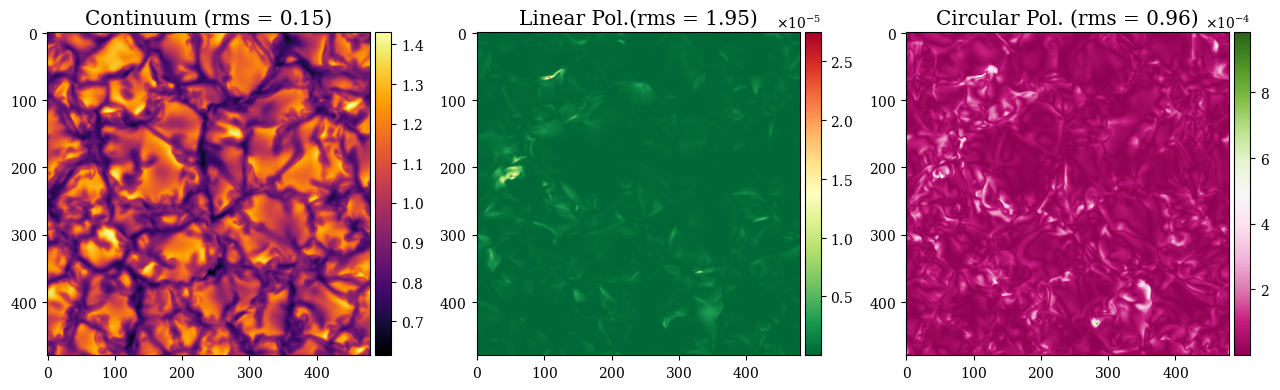

In [117]:
old_rms = [rms_calculation(old_mean_continuum), rms_calculation(old_norm_linear_polarization), rms_calculation(old_norm_circular_polarization)]
plot_polarizations(mean_continuum, old_norm_linear_polarization, old_norm_circular_polarization, old_rms)

### 4.1 Degrading spatial resolution

We are interested on working with Hinode/SOT-SP data for evaluating the applicability of our results on real data. For doing that, we need to apply the spatial and spectral resolutions

In [118]:
with fits.open(ptm / "hinode-MODEST" / "PSFs" / "hinode_psf_bin.0.16.fits") as hdul:
    psf_header = hdul[0].header
    psf = hdul[0].data #This PSF is already normalized.

psf = psf / psf.sum()

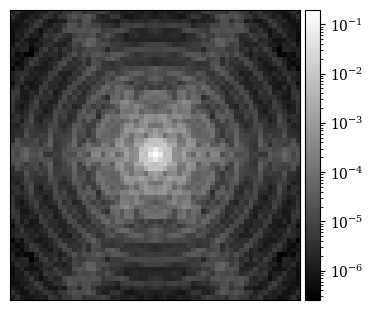

In [119]:
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(psf, norm=LogNorm(), cmap="gist_gray")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(images_output / "Hinode-SOT_psf.png", dpi=300)
plt.show()

In [120]:
from scipy.signal import fftconvolve
# Apply PSF convolution over each spectral step for each Stokes parameter
print("Applying Hinode PSF convolution on Stokes parameters...")
stokes_spatially_convolved = np.zeros_like(stokes)
for i in range(stokes.shape[-1]):
    for j in tqdm(range(stokes.shape[2])):
        stokes_spatially_convolved[:, :, j, i] = fftconvolve(stokes[:, :, j, i], psf, mode='same')

#Normalized signal for visualization
norm_stokes_spatially_convolved, mean_continuum_spatially_convolved = continuum_normalization(stokes_spatially_convolved, wl)
total_polarimetry_spatially_convolved, circular_polarimetry_spatially_convolved = spectropolarimetry(norm_stokes_spatially_convolved)

Applying Hinode PSF convolution on Stokes parameters...


100%|██████████| 300/300 [00:02<00:00, 122.89it/s]


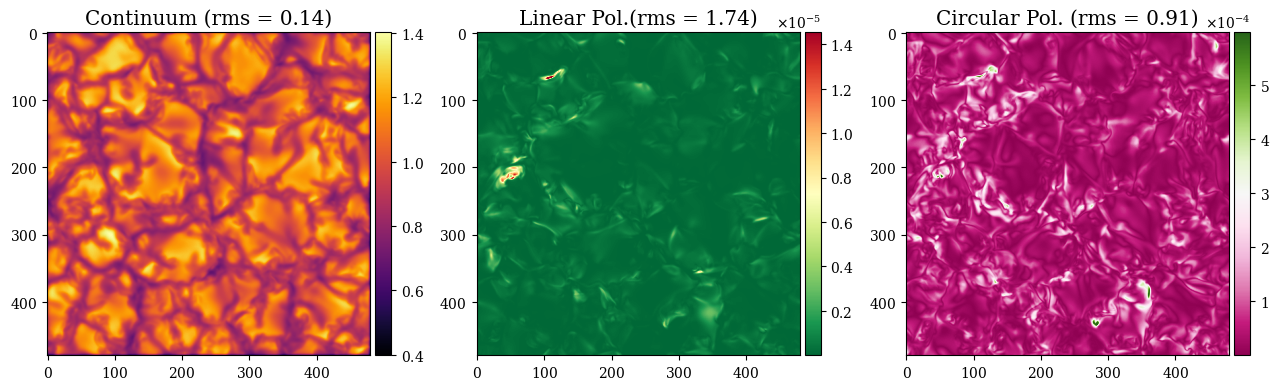

In [121]:
rms_spatially_convolved = [rms_calculation(mean_continuum_spatially_convolved), 
                            rms_calculation(total_polarimetry_spatially_convolved), 
                            rms_calculation(circular_polarimetry_spatially_convolved)]
                            
plot_polarizations(mean_continuum_spatially_convolved, total_polarimetry_spatially_convolved, circular_polarimetry_spatially_convolved, rms_spatially_convolved)

### 4.2 Degrading spectral resolution

In [122]:
lsf_hinode = pd.read_csv(ptm / "hinode-MODEST" / "PSFs" / "hinode_sp.spline.psf", sep = "\s+", header = None)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3302405/2396759674.py:1: SyntaxWarning: invalid escape sequence '\s'
  lsf_hinode = pd.read_csv(ptm / "hinode-MODEST" / "PSFs" / "hinode_sp.spline.psf", sep = "\s+", header = None)


In [123]:
lsf_wavelengths = lsf_hinode[0].values
lsf_values = lsf_hinode[1].values
lsf_interp = interp1d(lsf_wavelengths, lsf_values, kind = "cubic") 

lsf_wl_min = np.round(lsf_wavelengths.min()+0.010, 3)
lsf_wl_max = np.round(lsf_wavelengths.max()-0.010, 3)

step = wl[1] - wl[0]
new_kernel_wl = np.arange(lsf_wl_min, lsf_wl_max+step, step) #We are assuming that the values of the LSF are presented in amstrongs.
new_kernel_values = lsf_interp(new_kernel_wl)

print(f"LSF wavelengths range: {lsf_wl_min:0.3f} - {lsf_wl_max:0.3f}")


LSF wavelengths range: -0.060 - 0.060


Is important to normalize the LSF function for the signal to conserve its original energy

In [124]:
lsf_values = lsf_values / lsf_values.sum()
new_kernel_values = new_kernel_values / new_kernel_values.sum()

For our data, our LSF kernel looks like

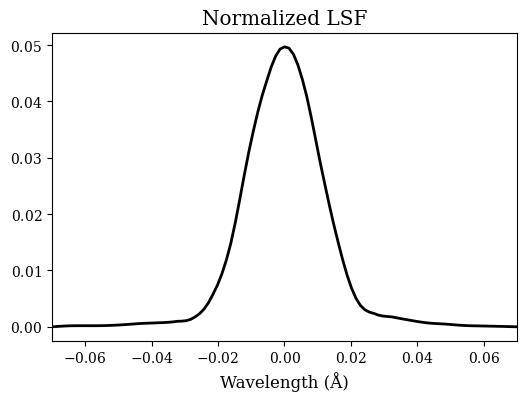

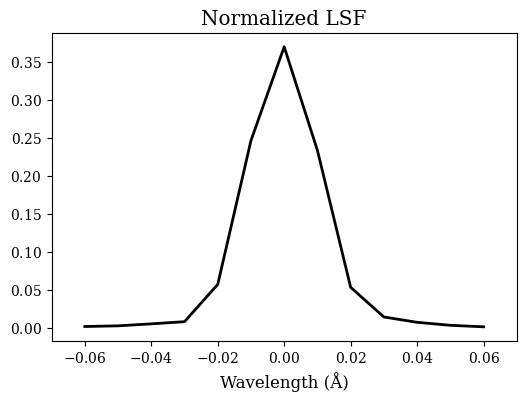

In [166]:
fig, ax = plt.subplots(figsize = (3*2,4))
ax.plot(lsf_wavelengths, lsf_values, label = "Original LSF", color = "black")
ax.set_title("Normalized LSF")
ax.set_xlim(lsf_wavelengths.min(), lsf_wavelengths.max())
ax.set_xlabel("Wavelength (Å)")
fig.savefig(images_output / "Hinode-SOT_lsf.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize = (3*2,4))
ax.plot(new_kernel_wl, new_kernel_values, label = "Original LSF", color = "black")
ax.set_title("Normalized LSF")
ax.set_xlim(lsf_wavelengths.min(), lsf_wavelengths.max())
ax.set_xlabel("Wavelength (Å)")
plt.show()

Convolve your stokes signal for each stokes on this lsf kernel

In [126]:
stokes_sptrl_convolved = np.zeros_like(stokes_spatially_convolved)

# Apply convolution for each Stokes parameter efficiently
for stk in tqdm(range(stokes_spatially_convolved.shape[-1])):
    stokes_sptrl_convolved[..., stk] = convolve1d(
        stokes_spatially_convolved[..., stk],               # Input: (nx, ny, n_lambda)
        weights=new_kernel_values,     # Kernel
        axis=-1,                       # Apply along wavelength axis
        mode='wrap'                    # Mimic periodic boundary as before
    )

100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


In [127]:
norm_stokes_sptrl_convolved, mean_continuum_sptrl_convolved = continuum_normalization(stokes_sptrl_convolved, wl)
total_polarimetry_sptrl_convolved, circular_polarimetry_sptrl_convolved = spectropolarimetry(norm_stokes_sptrl_convolved)

Equivalent Width without LSF for the tested pixel: 0.28 Å
Equivalent Width with LSF for the tested pixel: 0.28 Å


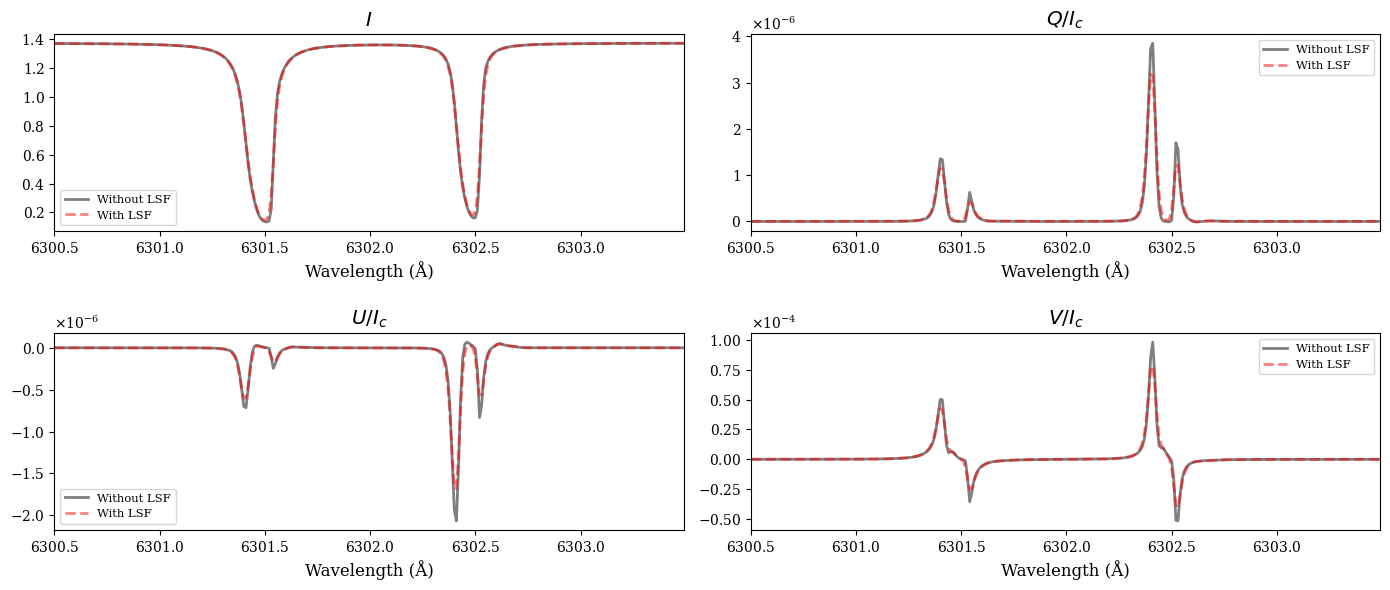

In [128]:
# Plot the Stokes parameters without the LSF and with the LSF
fig, ax = plt.subplots(2, 2, figsize=(2*7, 2*3))


for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(wl, norm_stokes_spatially_convolved[test_x, test_y, :, i], "k", label="Without LSF", linewidth=2, alpha=0.5)
    ax[i // 2, i % 2].plot(wl, norm_stokes_sptrl_convolved[test_x, test_y, :, i], "--r", label="With LSF", linewidth=2, alpha=0.5)
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(wl.min(), wl.max())
    ax[i // 2, i % 2].legend()

# Calculate Equivalent Width for Stokes I without LSF
continuum_level = stokes_spatially_convolved[test_x, test_y, :, 0].max()
equivalent_width_without_lsf = np.trapz(1 - stokes_spatially_convolved[test_x, test_y, :, 0] / continuum_level, wl)
print(f"Equivalent Width without LSF for the tested pixel: {equivalent_width_without_lsf:.2f} Å")

# Calculate Equivalent Width for Stokes I with LSF
continuum_level_convolved = stokes_sptrl_convolved[test_x, test_y, :, 0].max()
equivalent_width_with_lsf = np.trapz(1 - stokes_sptrl_convolved[test_x, test_y, :, 0] / continuum_level_convolved, wl)
print(f"Equivalent Width with LSF for the tested pixel: {equivalent_width_with_lsf:.2f} Å")

fig.tight_layout(w_pad=1.0, h_pad=2)
plt.show()


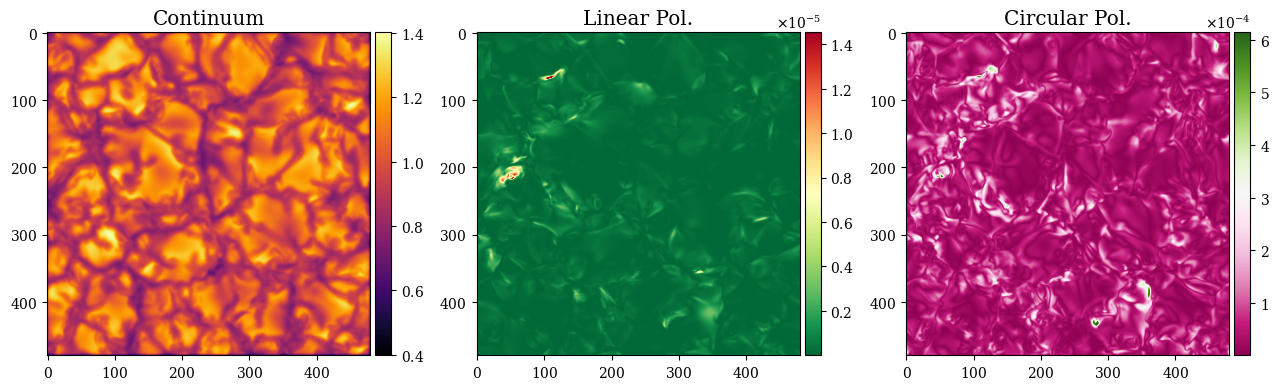

In [129]:
plot_polarizations(mean_continuum_sptrl_convolved, total_polarimetry_sptrl_convolved, circular_polarimetry_sptrl_convolved)

### 4.3 Spectral sampling

The spectral resolution on satellites doing spectropolarimetric measurements on the sun has, at best, 112 points of spectral resolution. This is the case for Hinode/SOT-SP, where the instrument information state in [Lites et al. 2013 (Solar Physics, 283, 579–599)](https://link.springer.com/article/10.1007/s11207-012-0206-3) that 
In this key paper (and related instrument papers), it's stated:

The Hinode/SP observes a spectral window centered near 6302 Å, specifically chosen to include:
- Fe I 6301.5 Å
- Fe I 6302.5 Å

The sampling is about 21.5 mÅ per pixel, covering 112 wavelength points, giving approximately 2.4 Å total range.

In [130]:
# Parameters from Hinode/SP FITS header (typical values)
NAXIS1 = 112
CRVAL1 = 6302.0    # Ångstroms
CDELT1 = 0.0215    # Å/pixel
CRPIX1 = 57        # Reference pixel

# Wavelength array calculation
new_wl = CRVAL1 + (np.arange(1, NAXIS1 + 1) - CRPIX1) * CDELT1

print("Interpolating Stokes parameters to Hinode/SP wavelengths...")
# Reshape stokes array for vectorized interpolation
stokes_reshaped = stokes_sptrl_convolved.reshape(-1, stokes_sptrl_convolved.shape[2], stokes_sptrl_convolved.shape[3])

# Create an array to store the interpolated values
stokes_to_hinode_wl = np.zeros((nx, ny, NAXIS1, stokes_sptrl_convolved.shape[-1]))

# Perform vectorized interpolation
for stk in tqdm(range(stokes_sptrl_convolved.shape[-1])):
    stokes_sptrl_interp = interp1d(wl, stokes_reshaped[:, :, stk], kind="cubic", axis=1)
    stokes_to_hinode_wl[..., stk] = stokes_sptrl_interp(new_wl).reshape(nx, ny, NAXIS1)

print("Interpolation finished!")


Interpolating Stokes parameters to Hinode/SP wavelengths...


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]

Interpolation finished!


The interpolated values compared to what we had before looks as the following plot

In [131]:
norm_stokes_to_hinode_wl, mean_continuum_stokes_to_hinode_wl = continuum_normalization(stokes_to_hinode_wl, new_wl)
total_polarimetry_to_hinode_wl, circular_polarimetry_to_hinode_wl = spectropolarimetry(norm_stokes_to_hinode_wl)

0.004495940583705646 0.004502780355367542


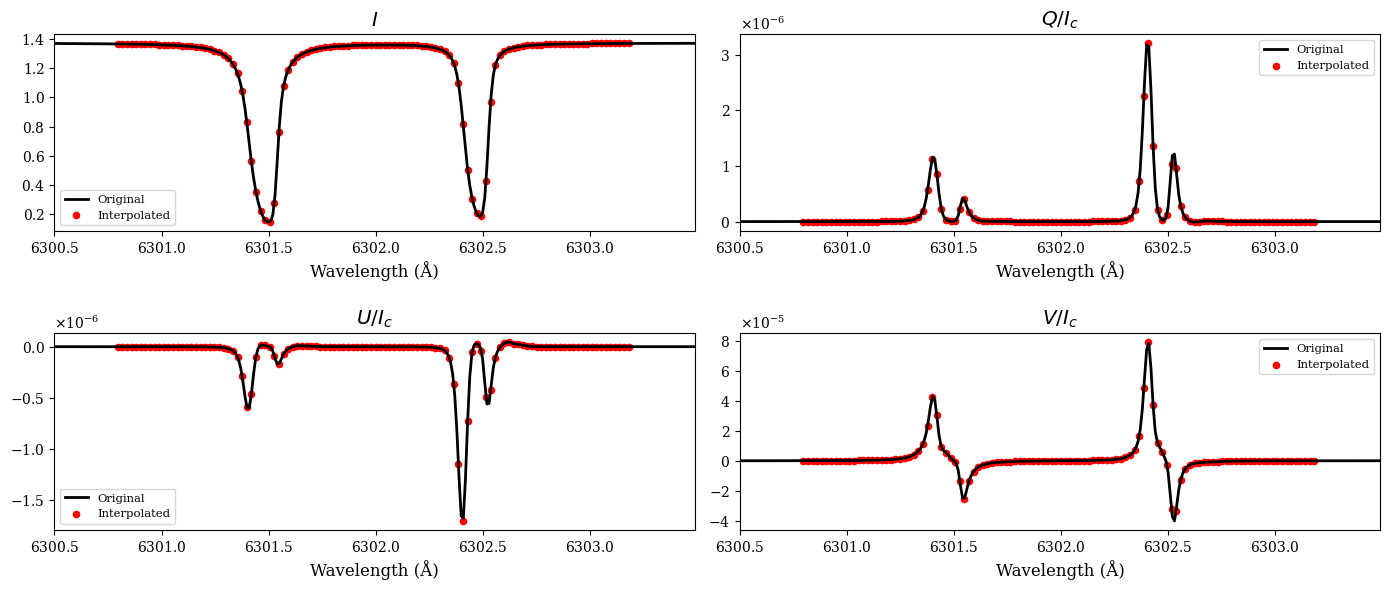

In [132]:
# Plot the previous Stokes parameters
fig, ax = plt.subplots(2, 2, figsize=(2*7, 2*3))

for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(wl, norm_stokes_sptrl_convolved[test_x, test_y, :, i], "k", label="Original")
    ax[i // 2, i % 2].scatter(new_wl, norm_stokes_to_hinode_wl[test_x, test_y, :, i], s=20, color="red", label="Interpolated")
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(wl.min(), wl.max())
    ax[i // 2, i % 2].legend()

fig.tight_layout(w_pad=1.0, h_pad=2)
fig.savefig(images_output / "stokes_comparison_plot.png", dpi=300)

print(norm_stokes_sptrl_convolved[...,3].max(), norm_stokes_to_hinode_wl[...,3].max())
plt.show()


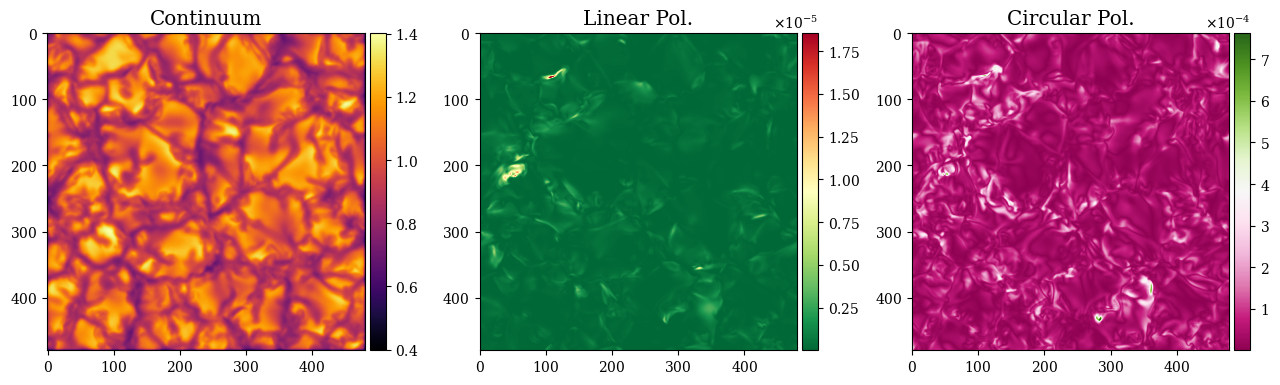

In [133]:
plot_polarizations(mean_continuum_stokes_to_hinode_wl, total_polarimetry_to_hinode_wl, circular_polarimetry_to_hinode_wl)

### 4.4 Pixel Surface Sampling

In [134]:
new_image_dimensions = resize.size
resampled_stokes = np.zeros((new_image_dimensions[0], new_image_dimensions[1], stokes_to_hinode_wl.shape[2], stokes_to_hinode_wl.shape[3]))

for stk in tqdm(range(stokes_to_hinode_wl.shape[-1])):
    for iwl in range(stokes_to_hinode_wl.shape[2]):
        resampled_stokes[..., iwl, stk] = resize(torch.tensor(stokes_to_hinode_wl[..., iwl, stk]).unsqueeze(0).unsqueeze(0)).numpy().squeeze()

100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


In [135]:
norm_resampled_stokes, mean_continuum_resampled = continuum_normalization(resampled_stokes, new_wl)
total_polarimetry_resampled, circular_polarimetry_resampled = spectropolarimetry(norm_resampled_stokes)

In [136]:
circular_polarimetry_resampled.shape

(103, 103)

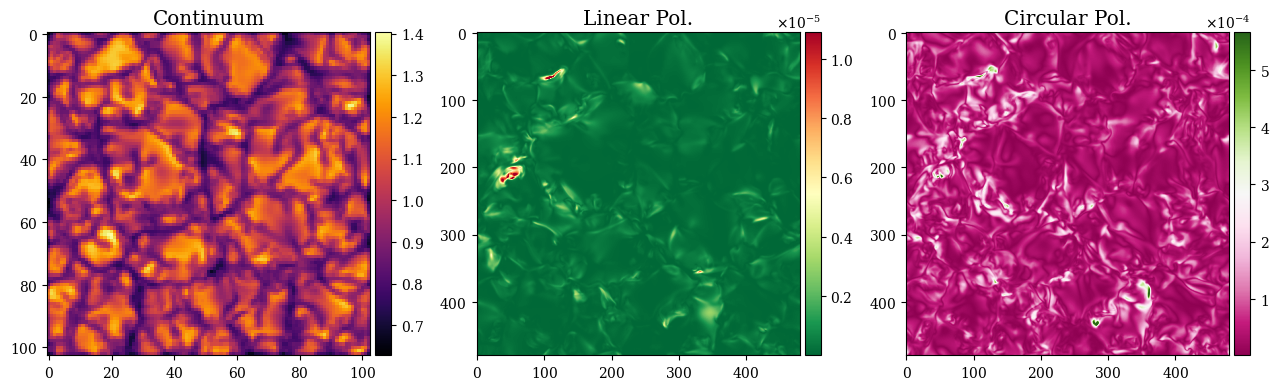

In [137]:
plot_polarizations(mean_continuum_resampled, total_polarimetry_resampled, circular_polarimetry_resampled)

### 4.5 Add some noise

Hinode data has, according to the paper of MODEST, $\sigma \approx  5.9 \times 10^{-4}\,I_c$. Let's add this noise to the our data.

In [138]:
# Add Gaussian noise to the resampled Stokes cube
level_of_noise = 1e-5
norm_stokes_with_noise = np.zeros_like(norm_resampled_stokes)
mean_continuum_with_noise = np.zeros_like(mean_continuum_resampled)


for jx in tqdm(range(resampled_stokes.shape[0])):
    for jy in range(resampled_stokes.shape[1]):
        for stk in range(resampled_stokes.shape[-1]):
            new_points = int(np.random.poisson(1))
            norm_stokes_with_noise[jx, jy, :, stk] = norm_resampled_stokes[jx, jy, :, stk] + level_of_noise * np.random.randn(NAXIS1) 
            mean_continuum_with_noise[jx,jy] = mean_continuum_resampled[jx,jy] + level_of_noise * np.random.randn(1)[0]

100%|██████████| 103/103 [00:00<00:00, 303.15it/s]


In [139]:
linear_polarization_with_noise, circular_polarization_with_noise = spectropolarimetry(norm_stokes_with_noise)

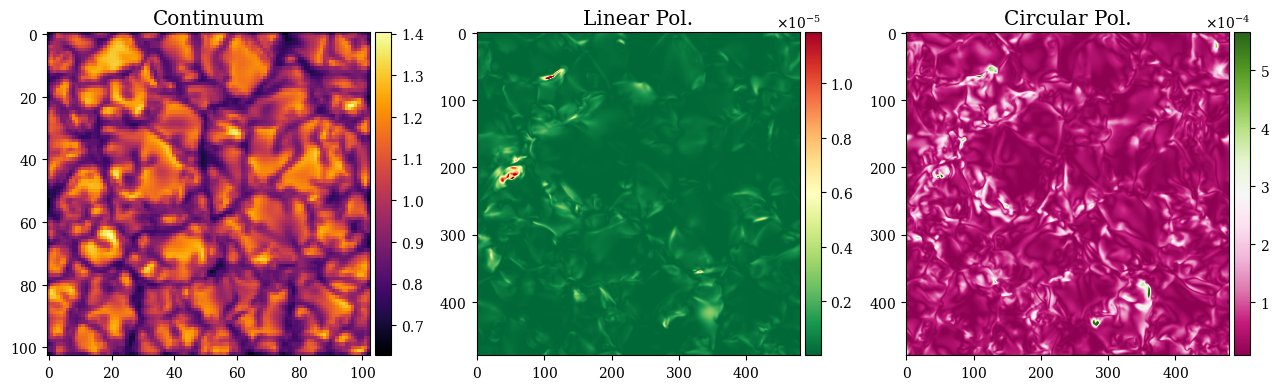

In [140]:
plot_polarizations(mean_continuum_with_noise, linear_polarization_with_noise, circular_polarization_with_noise)

### 4.6 Checking changes after processing

Let's see how our Stokes looked before the Hinode adaptation and after all the hinode processing.

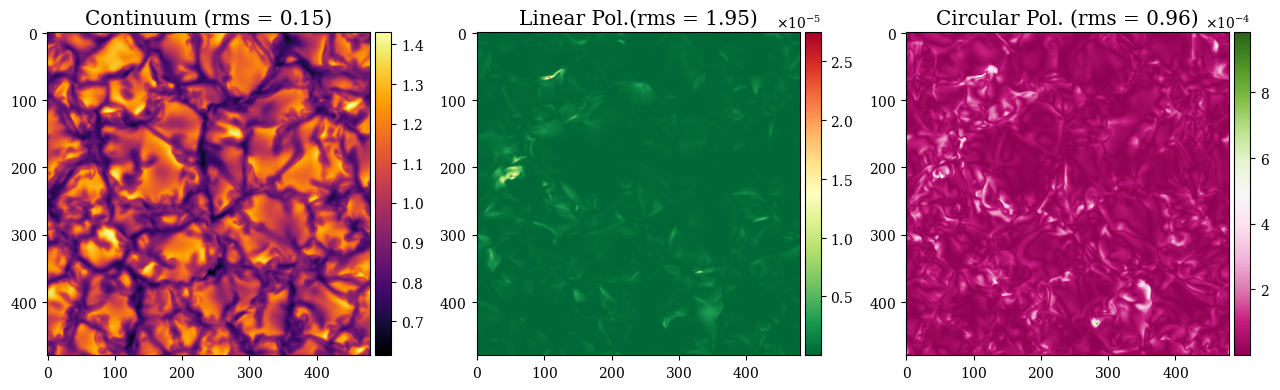

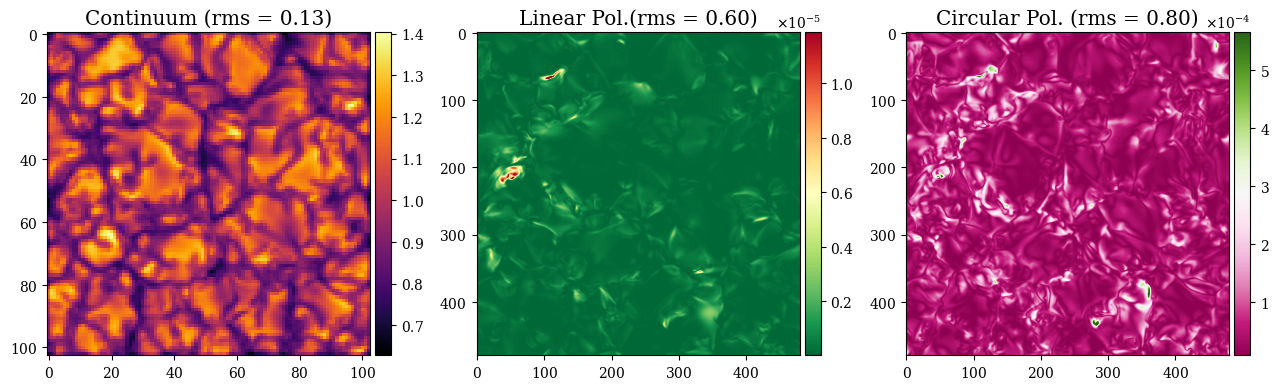

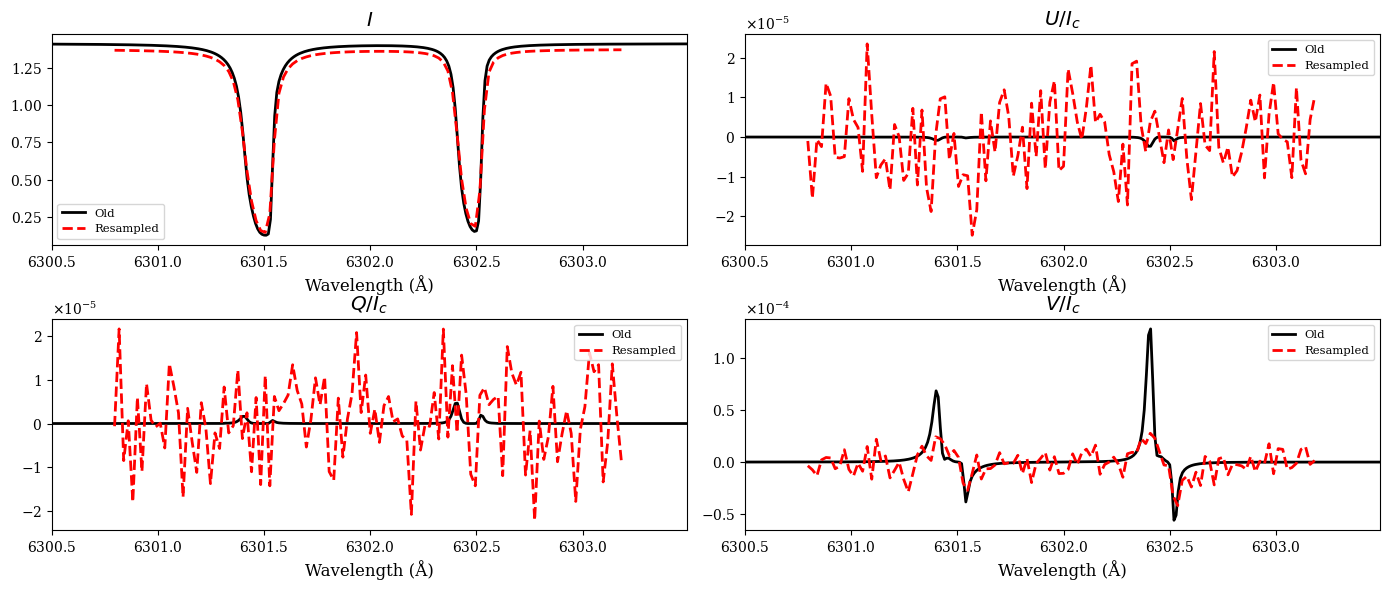

In [141]:
plot_polarizations(mean_continuum, old_norm_linear_polarization, old_norm_circular_polarization, old_rms)
rms_with_noise  = [rms_calculation(mean_continuum_with_noise), rms_calculation(linear_polarization_with_noise), rms_calculation(circular_polarization_with_noise)]
plot_polarizations(mean_continuum_with_noise, linear_polarization_with_noise, circular_polarization_with_noise, rms_with_noise)

# Define the pixel to be plotted
pixel_x, pixel_y = test_x, test_y

# Convert pixel coordinates to the new resampled size
resampled_pixel_x = int(pixel_x * resampled_stokes.shape[0] / stokes_to_hinode_wl.shape[0])
resampled_pixel_y = int(pixel_y * resampled_stokes.shape[1] / stokes_to_hinode_wl.shape[1])

fig, ax = plt.subplots(2,2, figsize=(7*2, 3*2))
# Plot the spectral plots for the selected pixel
for i in range(len(stokes_titles)):
    row, column = i % 2, i // 2
    ax[row, column].plot(wl, norm_stokes[pixel_x, pixel_y, :, i], "k", label="Old")
    ax[row, column].plot(new_wl, norm_stokes_with_noise[resampled_pixel_x, resampled_pixel_y, :, i], "--r", label="Resampled")
    ax[row, column].set_title(stokes_titles[i])
    ax[row, column].set_xlabel("Wavelength (Å)")
    ax[row, column].set_xlim(wl.min(), wl.max())
    ax[row, column].legend()

fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "stokes_comparison_plot.png", dpi=300)
plt.show()

## 5. Masking

### 5.1 Filtering the data by granular and intergranular zones

Granular and intergranular regions has different physicial behaviou, meaning that if we want to assess correctly the information on the calm sun we must balance the data we have over this two regions, meaning that we need to have the same amount on data on both. For this, we will apply a threshold used in computer vision for separating _foreground_ from _background_ over the intensity outside of the absorption lines. This parameter was selected in previous sections as the first value of the spectra over each pixel.

Text(0.5, 1.0, 'Intensity in the continuum')

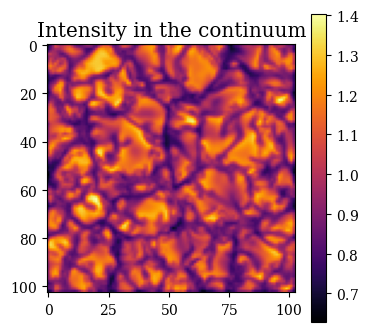

In [142]:
fig, ax = plt.subplots(figsize = (4,4))
im = ax.imshow(mean_continuum_with_noise, cmap = "inferno")
fig.colorbar(im, ax = ax)
ax.set_title("Intensity in the continuum")

Having the intensity in the continuum, let's apply the Otsu's threshold and check how the separation looks like

In [143]:
#Threshold definition
thresh_continuum = filters.threshold_otsu(mean_continuum_with_noise)

#Mask extraction
mean_continuum_mask = mean_continuum_with_noise > thresh_continuum
gran_mask =  np.ma.masked_array(mean_continuum_with_noise, mask=mean_continuum_mask).mask
inter_mask = np.ma.masked_array(mean_continuum_with_noise, mask=~mean_continuum_mask).mask

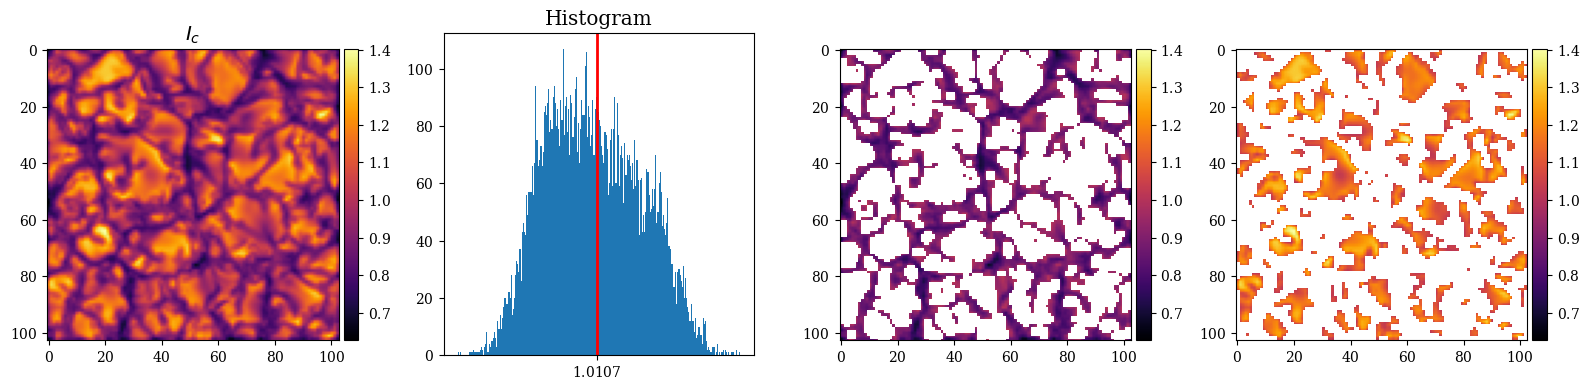

In [144]:
fig, ax = plt.subplots(1, 4, figsize=(4*4, 4))

cmap = "inferno"
im = ax[0].imshow(mean_continuum_with_noise, cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
vmin, vmax = [np.min(mean_continuum_with_noise), np.max(mean_continuum_with_noise)]
ax[0].set_title(r"$I_{c}$")

ax[1].hist(mean_continuum_with_noise.ravel(), bins=256)
ax[1].set_xticks([thresh_continuum])
ax[1].set_title('Histogram')
ax[1].axvline(thresh_continuum, color='r')

im2 = ax[2].imshow(np.ma.masked_array(mean_continuum_with_noise, mask=mean_continuum_mask), vmin=vmin, vmax=vmax, cmap=cmap)
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

im3 = ax[3].imshow(np.ma.masked_array(mean_continuum_with_noise, mask=~mean_continuum_mask), vmin=vmin, vmax=vmax, cmap=cmap)
divider3 = make_axes_locatable(ax[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)

fig.tight_layout()
fig.savefig(images_output / "Otsu_thres_I_stokes.png", transparent=False)
plt.show()

### 5.2 Masking through Polarimetric information

As you have seen, due to being in the quiet sun with very low magnetic fields, the linear polarization is negligible with respect to the noise, which means we can only obtain information from the line of sight component of the magnetic field. That is why we are only taking that component instead of the tree components for this experiment. Let's mask then the polarimetric information corresponding to this zones of high LOS magnetic field.

In [145]:
# Denoise
denoised = filters.gaussian(circular_polarization_with_noise, sigma = 2)

In [146]:
# Apply Sauvola threshold
thresh_circular = filters.threshold_otsu(denoised)
circular_polarization_mask = denoised < thresh_circular


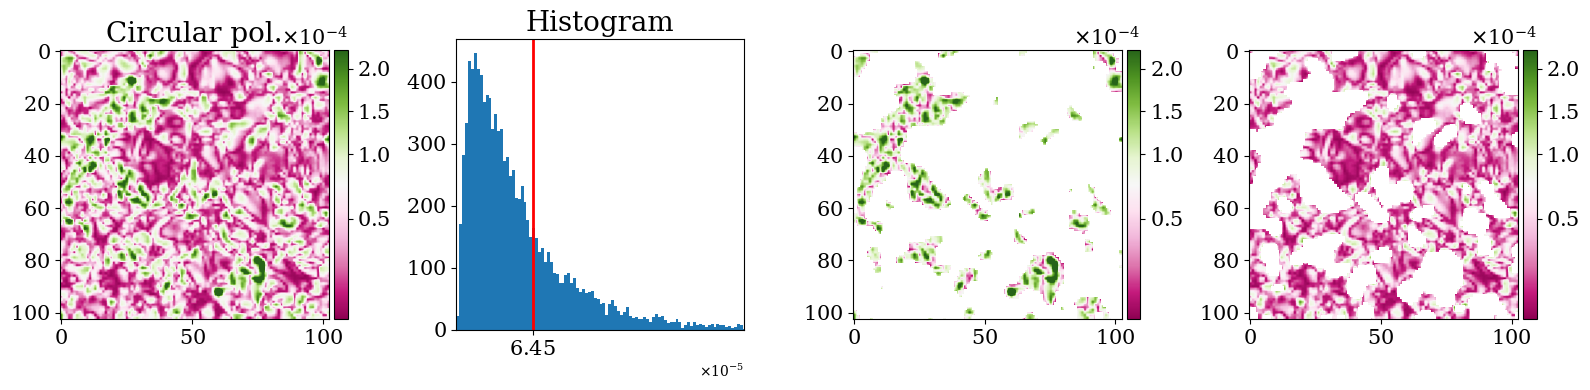

In [147]:
fig, ax = plt.subplots(1, 4, figsize=(4*4, 4))

cmap = "PiYG"
q_low, q_high = np.percentile(circular_polarization_with_noise.ravel(), [0, 99])
norm = TwoSlopeNorm(vcenter=thresh_circular, vmin=q_low, vmax=q_high)

im = ax[0].imshow(circular_polarization_with_noise, cmap=cmap, norm = norm)
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax1)
vmin, vmax = [np.min(circular_polarization_with_noise), np.max(circular_polarization_with_noise)]
ax[0].set_title("Circular pol.", fontsize=20)

ax[1].hist(circular_polarization_with_noise.ravel(), bins=256)
ax[1].set_xticks(np.array([thresh_circular]))
ax[1].tick_params(axis='x', labelsize=15)
ax[1].set_title('Histogram', fontsize=20)
ax[1].axvline(thresh_circular, color='r')

# Calculate quantiles for x-axis limits
q1, q99 = np.percentile(circular_polarization_with_noise.ravel(), [1, 99])
ax[1].set_xlim(q_low, q_high)


im2 = ax[2].imshow(np.ma.masked_array(circular_polarization_with_noise, mask=circular_polarization_mask), cmap=cmap, norm = norm)
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)
 
im3 = ax[3].imshow(np.ma.masked_array(circular_polarization_with_noise, mask=~circular_polarization_mask), cmap=cmap, norm = norm)
divider3 = make_axes_locatable(ax[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=15)
    axis.tick_params(axis='both', which='minor', labelsize=15)

for cax in [cax1, cax2, cax3]:
    cax.tick_params(axis='both', which='major', labelsize=15)
    cax.tick_params(axis='both', which='minor', labelsize=12)
    cax.yaxis.get_offset_text().set_size(15)


fig.tight_layout()
fig.savefig(images_output / "Otsu_thres_I_stokes.png", transparent=False)
plt.show()

### 5.3 Create composite mask

In [148]:
# Assuming `mean_continuum` and `circular_polarization` are your data arrays
# and `mean_continuum_mask` and `circular_polarization_mask` are your binary masks

# Create composite masks
foreground_mean_continuum = mean_continuum_mask == 1
background_mean_continuum = mean_continuum_mask == 0
foreground_circular_polarization = circular_polarization_mask == 1
background_circular_polarization = circular_polarization_mask == 0

# Combine masks to get the four categories
combined_foreground = foreground_mean_continuum & foreground_circular_polarization
combined_background = background_mean_continuum & background_circular_polarization
combined_foreground_mean_background_circular = foreground_mean_continuum & background_circular_polarization
combined_background_mean_foreground_circular = background_mean_continuum & foreground_circular_polarization

# Extract points for each category
points_foreground = np.where(combined_foreground)
points_background = np.where(combined_background)
points_foreground_mean_background_circular = np.where(combined_foreground_mean_background_circular)
points_background_mean_foreground_circular = np.where(combined_background_mean_foreground_circular)

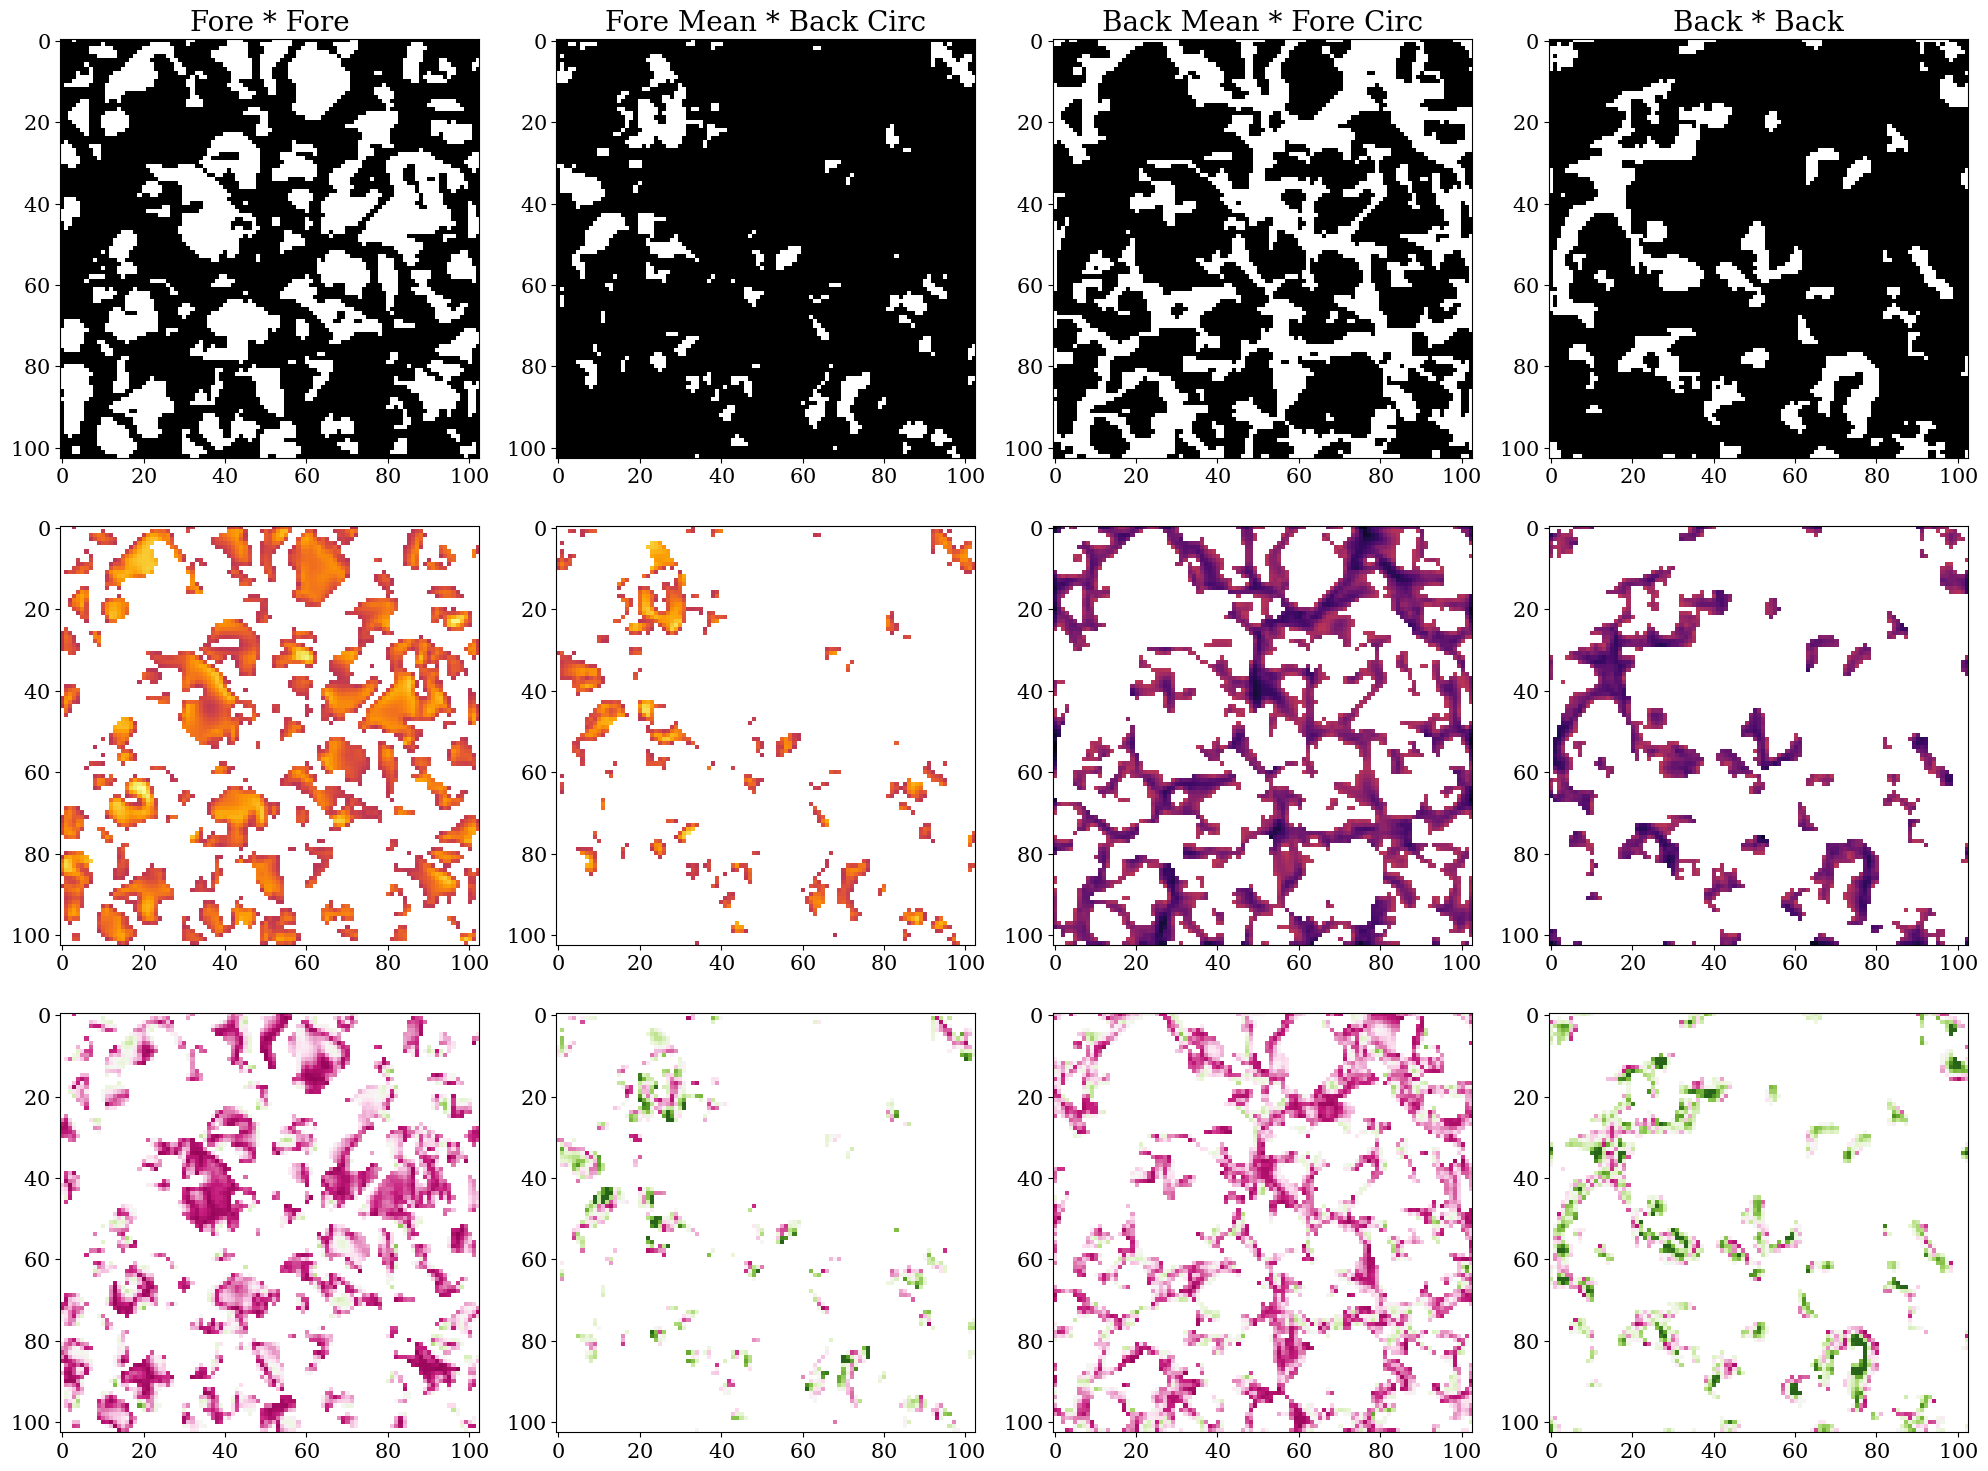

In [149]:
fig, ax = plt.subplots(3, 4, figsize=(5*4, 5*3))

# Original masks visualization
ax[0, 0].imshow(combined_foreground, cmap='gray')
ax[0, 0].set_title('Fore * Fore', fontsize=20)

ax[0, 1].imshow(combined_foreground_mean_background_circular, cmap='gray')
ax[0, 1].set_title('Fore Mean * Back Circ', fontsize=20)


ax[0, 2].imshow(combined_background_mean_foreground_circular, cmap='gray')
ax[0, 2].set_title('Back Mean * Fore Circ', fontsize=20)


ax[0, 3].imshow(combined_background, cmap='gray')
ax[0, 3].set_title('Back * Back', fontsize=20)


# Apply masks on mean_continuum and circular_polarimetry
# Apply masks on mean_continuum and circular_polarimetry
vmin = mean_continuum_with_noise.min()
vmax = mean_continuum_with_noise.max()
ax[1, 0].imshow(np.ma.masked_array(mean_continuum_with_noise, mask=~combined_foreground), cmap='inferno', vmin = vmin, vmax = vmax)
ax[1, 1].imshow(np.ma.masked_array(mean_continuum_with_noise, mask=~combined_foreground_mean_background_circular), cmap='inferno', vmin = vmin, vmax = vmax)
ax[1, 2].imshow(np.ma.masked_array(mean_continuum_with_noise, mask=~combined_background_mean_foreground_circular), cmap='inferno', vmin = vmin, vmax = vmax)
ax[1, 3].imshow(np.ma.masked_array(mean_continuum_with_noise, mask=~combined_background), cmap='inferno', vmin = vmin, vmax = vmax)


q_low, q_high = np.percentile(circular_polarization_with_noise.ravel(), [0, 99])
norm = TwoSlopeNorm(vcenter=thresh_circular, vmin=q_low, vmax=q_high)
ax[2, 0].imshow(np.ma.masked_array(circular_polarization_with_noise, mask=~combined_foreground), cmap='PiYG', norm = norm)
ax[2, 1].imshow(np.ma.masked_array(circular_polarization_with_noise, mask=~combined_foreground_mean_background_circular), cmap='PiYG', norm = norm)
ax[2, 2].imshow(np.ma.masked_array(circular_polarization_with_noise, mask=~combined_background_mean_foreground_circular), cmap='PiYG', norm = norm)
ax[2, 3].imshow(np.ma.masked_array(circular_polarization_with_noise, mask=~combined_background), cmap='PiYG', norm = norm)

for axis in ax.ravel():
    axis.tick_params(axis='both', which='major', labelsize=15)
    axis.tick_params(axis='both', which='minor', labelsize=15)

fig.tight_layout()
plt.show()

#### 5.4 Masking the Atm and Stokes data

Having all the masks, let's create the combined masking so that we can extract and balance the data of this features. The main mask will be the mean continuum foreground-background, and for both foreground and background it will be obtained the corresponding foreground and background of circular polarimetric values.

In [150]:
# Balancing the quantity of data from the four new masks by randomly dropping elements from the greater zone.
print("Balancing data...")

# Function to balance data between two masks
def balance_data(mask1, mask2, data):
    len1 = np.sum(mask1)
    len2 = np.sum(mask2)
    np.random.seed(50)
    if len1 < len2:
        index_select = np.random.choice(range(len2), size=(len1,), replace=False)
        balanced_data1 = data[mask1]
        balanced_data2 = data[mask2][index_select]
    elif len1 > len2:
        index_select = np.random.choice(range(len1), size=(len2,), replace=False)
        balanced_data1 = data[mask1][index_select]
        balanced_data2 = data[mask2]
    else:
        balanced_data1 = data[mask1]
        balanced_data2 = data[mask2]

    return balanced_data1, balanced_data2

# Balance data for each pair of masks
muram_box_balanced_1, muram_box_balanced_2 = balance_data(combined_foreground, combined_foreground_mean_background_circular, resampled_atm)
stokes_balanced_1, stokes_balanced_2 = balance_data(combined_foreground, combined_foreground_mean_background_circular, norm_stokes_with_noise)

muram_box_balanced_3, muram_box_balanced_4 = balance_data(combined_background_mean_foreground_circular, combined_background, resampled_atm)
stokes_balanced_3, stokes_balanced_4 = balance_data(combined_background_mean_foreground_circular, combined_background, norm_stokes_with_noise)



print("Done")

Balancing data...
Done


In [151]:
# Combine balanced data
muram_box_leveraged = np.concatenate((muram_box_balanced_1, muram_box_balanced_2, muram_box_balanced_3, muram_box_balanced_4), axis=0)
stokes_leveraged = np.concatenate((stokes_balanced_1, stokes_balanced_2, stokes_balanced_3, stokes_balanced_4), axis=0)

In [152]:
muram_box_leveraged.shape, stokes_leveraged.shape

((5536, 21, 4), (5536, 112, 4))